<a href="https://colab.research.google.com/github/L-Gaysina/Data_analytics/blob/main/tumor-microenvironment-analysis/tumor_microenvironment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ датасета по пространственной транскриптомике пациентов с плоскоклеточным раком
Выполнила Гайсина Лиана Ильдаровна


## Задачи:
Вам нужно проанализировать биоинформатический датасет ([ссылка на скачивание](https://lms.skillfactory.ru/asset-v1:SkillFactory+MFTIBIO+SEP2023+type@asset+block@community_dataset.csv)) по пространственной транскриптомике ([дополнительная информация по теме](https://institut-curie.org/popin/spatial-omics)) пациентов с плоскоклеточным раком.

В нем клетки (колонка `cell_type`) объединены в микроокружения (колонка `cell_interaction`) в зависимости от взаимодействия этих клеток. Вашей основной задачей будет поиск отличий в организации микроокружения у пожилых и молодых пациентов (колонка `age_group`).

Также в датасете есть следующие колонки:


`distance_to_vasculature` — расстояние до ближайших сосудов;

`distance_to_largest_cell` — расстояние до ближайшей крупной клетки;

`immune_marker_1 `— экспрессия иммунного маркера 1 в данной клетке;

`immune_marker_2` — экспрессия иммунного маркера 2 в данной клетке;

`cell_type` — тип клетки;

`area_of_cell` — размер клетки;

`case_id` — уникальный ID пациента.

Вам необходимо:
В ноутбуке проанализировать датасет и сделать статистически обоснованные выводы. Ограничения в использовании библиотек/функций: нет, при желании можно воспользоваться pandasql для обработки данных. Не забывайте про PEP8. Ответы в виде графиков со стат-значимостью на них тоже считаются правильным ответом, не забывайте обосновывать применимость стат-теста.

In [ ]:
# @title Импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

from statsmodels.formula.api import ols
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import combine_pvalues

# Загрузка данных и предварительный анализ:

In [ ]:
url = 'https://lms.skillfactory.ru/asset-v1:SkillFactory+MFTIBIO+SEP2023+type@asset+block@community_dataset.csv'
data = pd.read_csv(url)

In [ ]:
data.head()

distance_to_vasculature  distance_to_largest_cell  immune_marker_1  \
0               988.509380                612.076506        10.803755   
1               787.852379                637.787202        11.749179   
2               960.635580                700.283468        15.124372   
3               702.033032                676.409695        14.221883   
4               830.399371                863.269930        19.978977   

   immune_marker_2 cell_interaction     cell_type  case_id  area_of_cell  \
0       187.998971      community_1  Stroma cells      891           185   
1       155.357076      community_1  Stroma cells      891           209   
2       182.626888      community_2  Stroma cells      891           254   
3       158.381917      community_3  Unclassified      891           156   
4       159.071269      community_3  Unclassified      891           194   

     age_group  
0  elder_group  
1  elder_group  
2  elder_group  
3  elder_group  
4  elder_group

In [ ]:
# @title Проверяем наличие дубликатов в данных.

def find_duplicates(data):
    duplicates = data[data.duplicated(keep=False)]
    num_duplicates = duplicates.shape[0]

    if num_duplicates == 0:
        print('Дубликаты не найдены')
    else:
        print(f'Число явных дублей: {num_duplicates}')

    return duplicates

# Проверяем наличие дубликатов
data_duplicates = find_duplicates(data)

Дубликаты не найдены


In [ ]:
# @title Проверяем наличие неинформативных признаков в данных.

def check_low_information_cols(data):
    low_information_cols = []

    for col in data.columns:
        top_freq = data[col].value_counts(normalize=True).max()
        nunique_ratio = data[col].nunique() / data[col].count()

        if top_freq > 0.95 or nunique_ratio > 0.95:
            low_information_cols.append(col)
            if top_freq > 0.95:
                print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
            if nunique_ratio > 0.95:
                print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

    if not low_information_cols:
        print("В данных нет неинформативных признаков.")
    return low_information_cols

# Проверяем наличие неинформативных признаков в данных
low_info_cols = check_low_information_cols(data)

distance_to_vasculature: 100.0% уникальных значений
distance_to_largest_cell: 100.0% уникальных значений


In [ ]:
# @title Провеяем наличие пропусков в данных.

def check_missing_values(data):
    cols_null_percent = data.isnull().mean() * 100
    cols_with_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)

    if cols_with_null.empty:
        print("Пропущенных значений нет.")
    else:
        fig, axes = plt.subplots(1, 2, figsize=(18, 6))

        # Карта пропусков
        sns.heatmap(data.isnull(), ax=axes[0])
        axes[0].set_title('Тепловая карта пропущенных значений')

        # Гистограмма процента пропусков в каждой колонке
        bar_plot = sns.barplot(x=cols_with_null.index, y=cols_with_null.values, ax=axes[1], color='black')
        bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=90)
        axes[1].set_ylabel('Процент, %')
        axes[1].set_xlabel('Признак')
        axes[1].set_title('Пропущенные значения')

        plt.tight_layout()
        plt.show()

# Провеяем наличие пропусков в данных.
check_missing_values(data)

Пропущенных значений нет.


#Задача 1.а


Есть ли стат-значимость между типом клетки и размером клетки (`area_of_cell`), добавьте hue по возрастным группам.

В качестве ответов можно приводить box_plot/swarplot, где по одной оси будет тип клеток, а по другой — оцениваемая вами статистика.


In [ ]:
# Расчет среднего значения площади клеток для каждого типа клетки и возрастной группы
mean_area = data.groupby(['cell_type', 'age_group'])['area_of_cell'].mean().reset_index()
mean_area.head(16)

cell_type    age_group  area_of_cell
0     Blood cells  elder_group    328.142035
1     Blood cells  young_group    326.284284
2      Bone cells  elder_group    308.521739
3      Bone cells  young_group    290.379852
4   Immune type 1  elder_group    255.677827
5   Immune type 1  young_group    244.812876
6   Immune type 2  elder_group    227.658330
7   Immune type 2  young_group    221.531167
8   Largest cells  elder_group    613.687144
9   Largest cells  young_group   1460.441839
10   Stroma cells  elder_group    244.781365
11   Stroma cells  young_group    254.555703
12   Unclassified  elder_group    225.895344
13   Unclassified  young_group    235.383336
14    Vasculature  elder_group    244.684783
15    Vasculature  young_group    231.173077

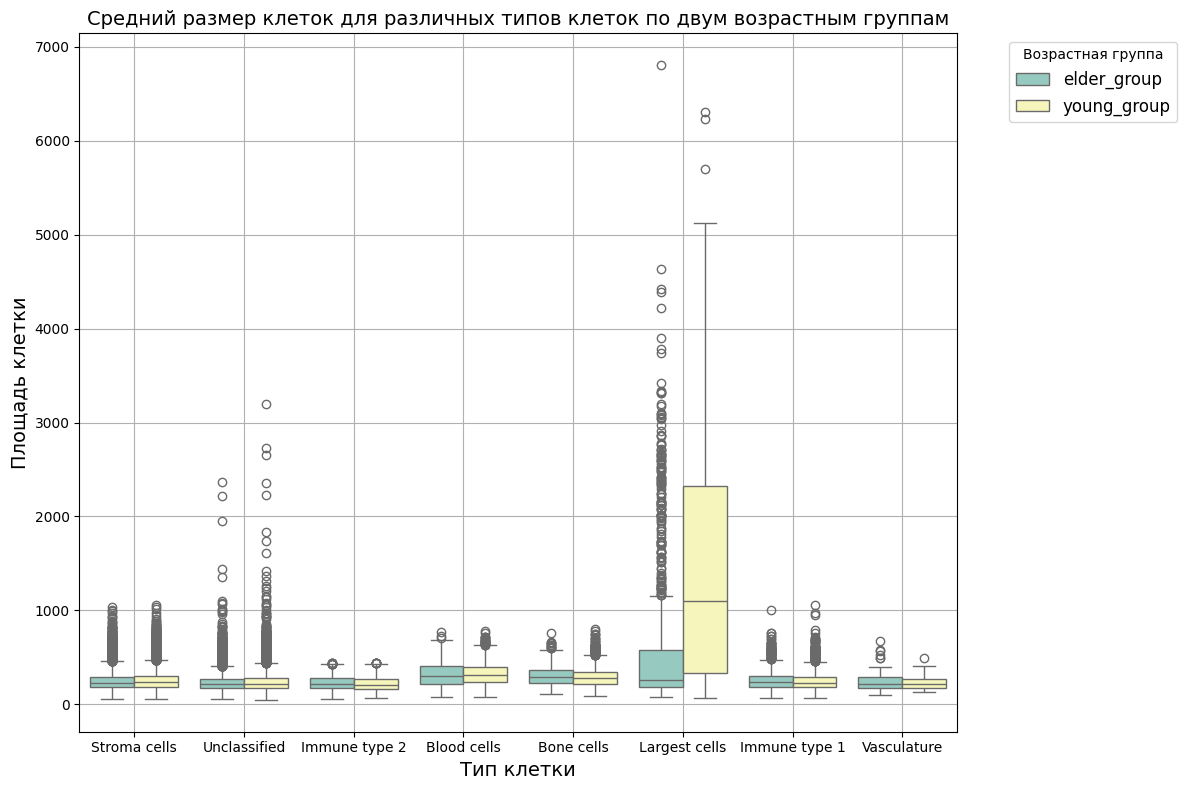

In [ ]:
# Построение графика
plt.figure(figsize=(12, 8))
sns.boxplot(x='cell_type', y='area_of_cell', hue='age_group', data=data, palette="Set3")
plt.title('Средний размер клеток для различных типов клеток по двум возрастным группам', fontsize=14)
plt.ylabel('Площадь клетки', fontsize=14)
plt.xlabel('Тип клетки', fontsize=14)
plt.grid(True)
plt.legend(title='Возрастная группа', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

*  Среди всех типов клеток, наиболее значительное различие в размерах клеток между
возрастными группами наблюдается у "Largest cells" (Большие клетки), где медиана и распределение размеров клеток младшей возрастной группы значительно выше, чем у старшей.

*  Для других типов клеток медианы размеров клеток между двумя возрастными группами кажутся схожими, с некоторым перекрытием между межквартильными размахами, что указывает на менее выраженное различие в размерах.

Таким образом, наблюдения могут указывать на различия в размерах клеток между возрастными группами для "Largest cells". Однако, для статистической значимости этих различий, помимо визуального анализа боксплотов, необходимо провести статистические тесты.

 ## Тест Шапиро-Уилка
Ссылка на документацию по тесту Шапиро-Уилка: [scipy.stats.shapiro](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)

Тест Шапиро-Уилка проверяет:

`H0` :  Данные соответсвуют нормальному распределению.

`H1` :  Данные соответсвуют распределению отличному от нормального.


In [ ]:
# @title Тест Шапиро-Уилка

def shapiro_wilk_test_visualization(data, column_name, alpha=0.05):
    """
    Выполнение теста Шапиро-Уилка на нормальность для каждой уникальной комбинации 'cell_type' и 'age_group' в данных.

    Параметры:
    data (pd.DataFrame): Датафрейм с данными.
    column_name (str): Название столбца, для которого выполняется тест.
    alpha (float): Уровень значимости для теста Шапиро-Уилка.
    """
    # комбинируем 'cell_type' и 'age_group'
    combinations = data.groupby(['cell_type', 'age_group'])

    for (cell_type, age_group), group in combinations:
        shapiro_test = stats.shapiro(group[column_name])

        print(f"\nКомбинация: Тип клетки = {cell_type}, Возрастная группа = {age_group}")
        print(f"Тест Шапиро-Уилка: Статистика = {shapiro_test.statistic}, P-value = {shapiro_test.pvalue}")

        if shapiro_test.pvalue > alpha:
            print('Данные соответсвуют нормальному распределению. (Принимаем H0)')
        else:
            print('Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)')

        # Гистограмма
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.hist(group[column_name], bins=15, color='skyblue', edgecolor='black')
        plt.title(f'Гистограмма {column_name}\n{cell_type}, {age_group}')
        plt.xlabel(column_name)
        plt.ylabel('Частота')

        # Q-Q график
        plt.subplot(1, 2, 2)
        stats.probplot(group[column_name], dist="norm", plot=plt)
        plt.title(f'Q-Q график {column_name}\n{cell_type}, {age_group}')
        plt.tight_layout()
        plt.show()



Комбинация: Тип клетки = Blood cells, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.9638803601264954, P-value = 5.183330986646695e-10
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


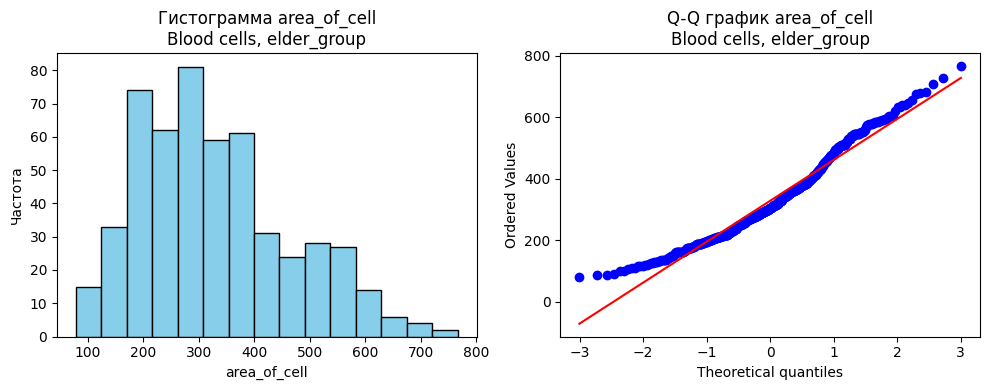


Комбинация: Тип клетки = Blood cells, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.9703012704849243, P-value = 2.1042767963977946e-21
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


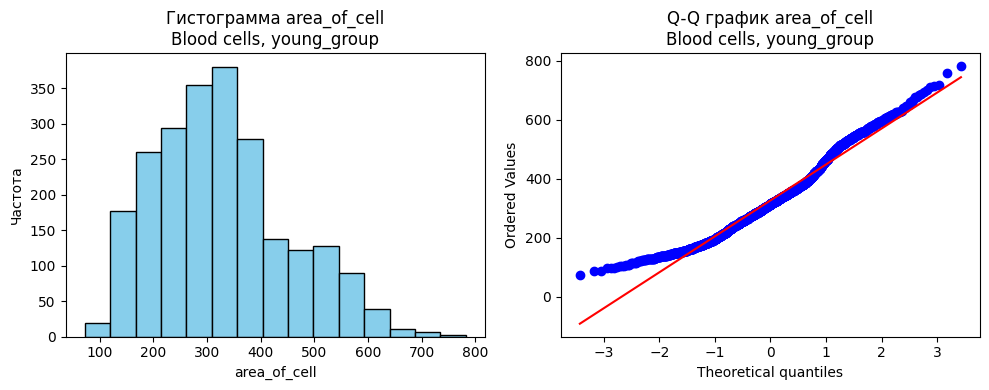


Комбинация: Тип клетки = Bone cells, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.9468902945518494, P-value = 1.2447218256106396e-10
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


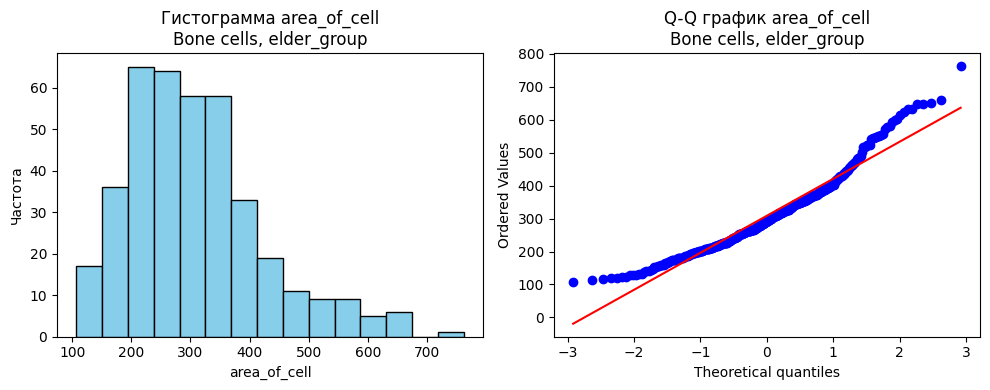


Комбинация: Тип клетки = Bone cells, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.934744656085968, P-value = 8.514108968429559e-30
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


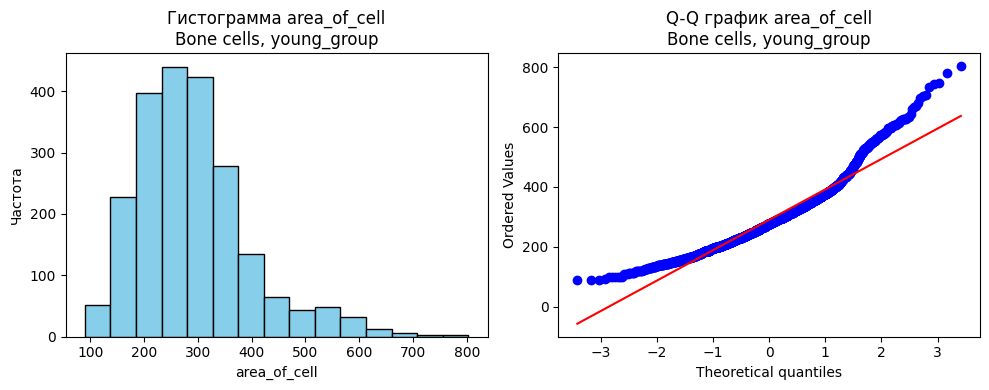


Комбинация: Тип клетки = Immune type 1, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.9030000567436218, P-value = 1.4941454786522319e-30
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


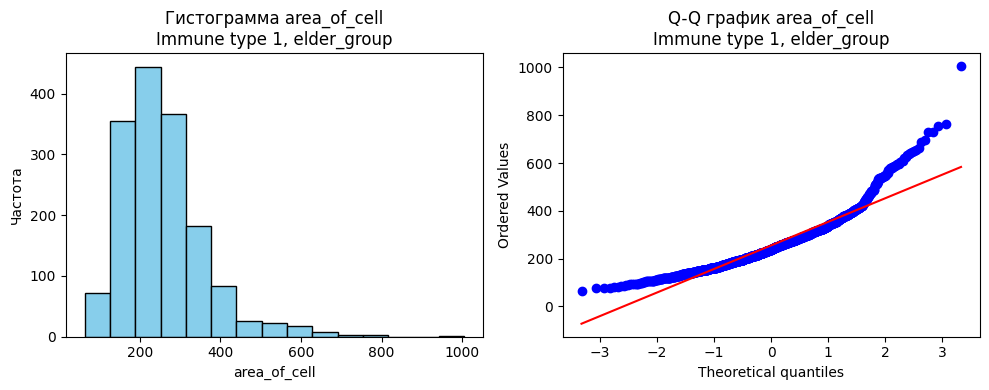


Комбинация: Тип клетки = Immune type 1, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.8988940119743347, P-value = 1.401298464324817e-45
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


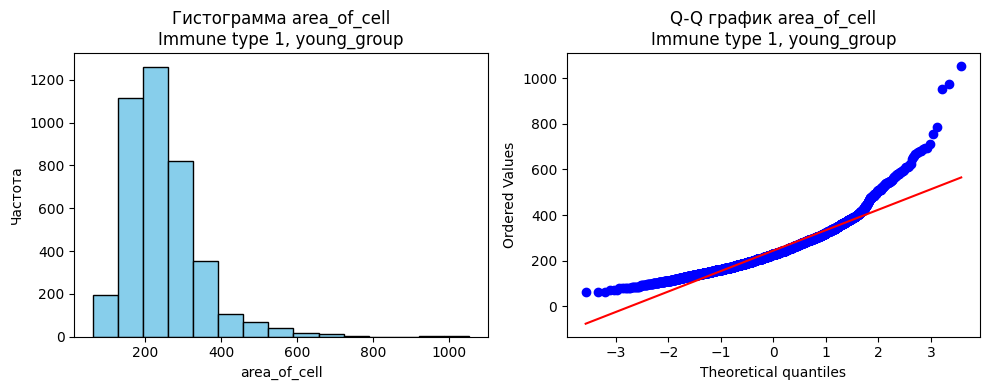

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Комбинация: Тип клетки = Immune type 2, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.9850736260414124, P-value = 1.766961760847569e-27
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


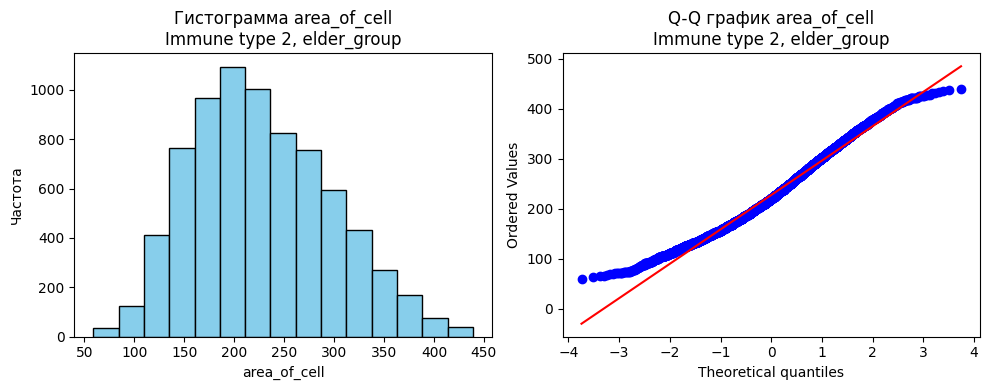


Комбинация: Тип клетки = Immune type 2, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.9570052623748779, P-value = 1.1210387714598537e-44
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


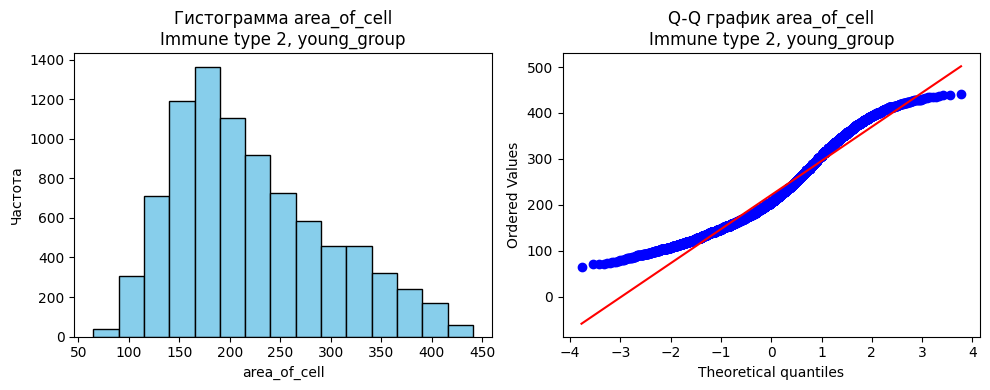


Комбинация: Тип клетки = Largest cells, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.6196429133415222, P-value = 3.8383526755706794e-40
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


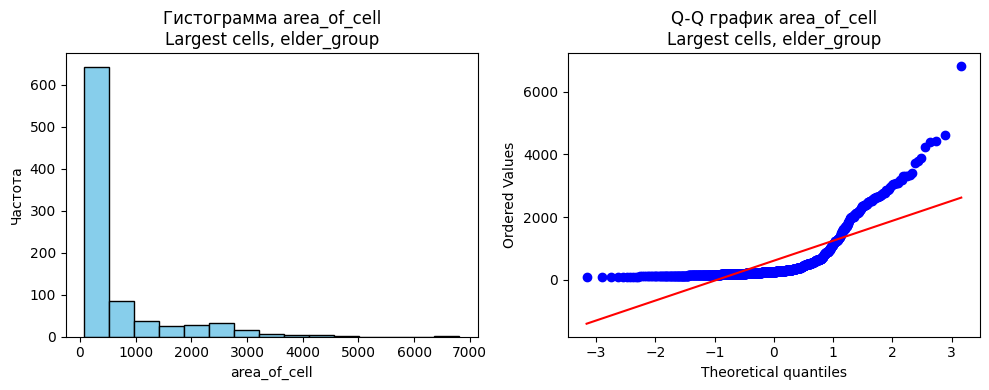


Комбинация: Тип клетки = Largest cells, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.8971453905105591, P-value = 1.3339217284187455e-26
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


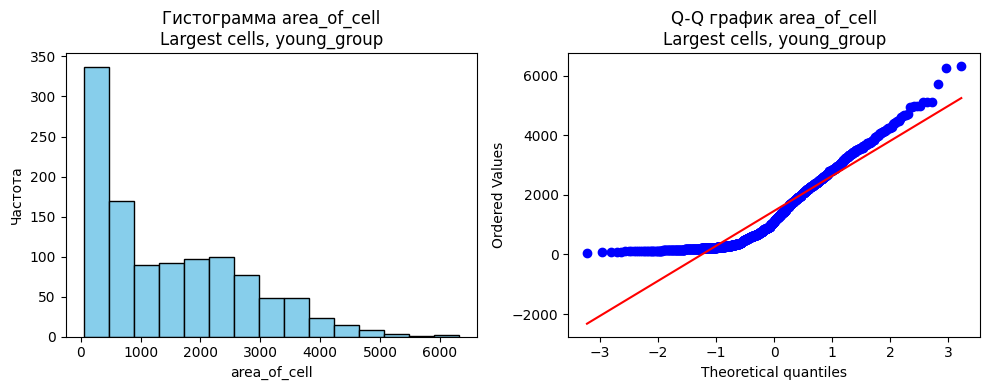


Комбинация: Тип клетки = Stroma cells, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.9169391989707947, P-value = 0.0
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


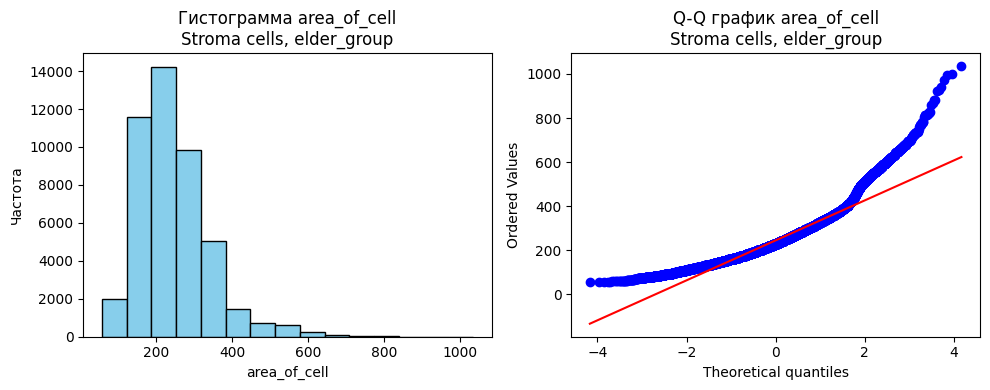


Комбинация: Тип клетки = Stroma cells, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.9261727929115295, P-value = 0.0
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


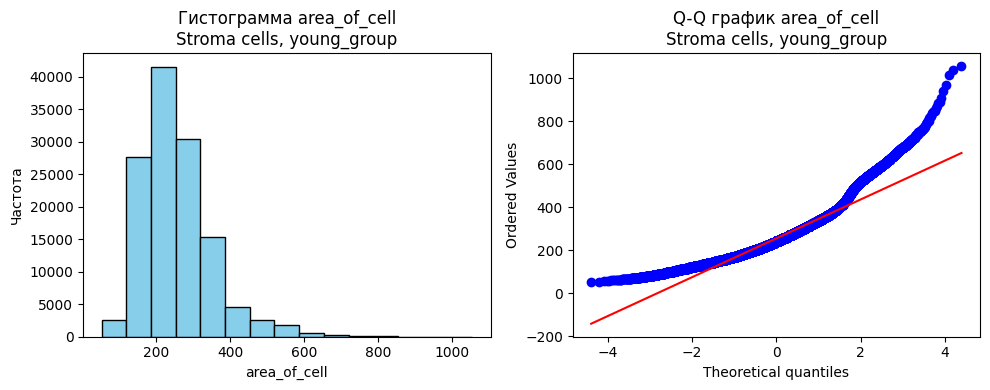


Комбинация: Тип клетки = Unclassified, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.8417705297470093, P-value = 0.0
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


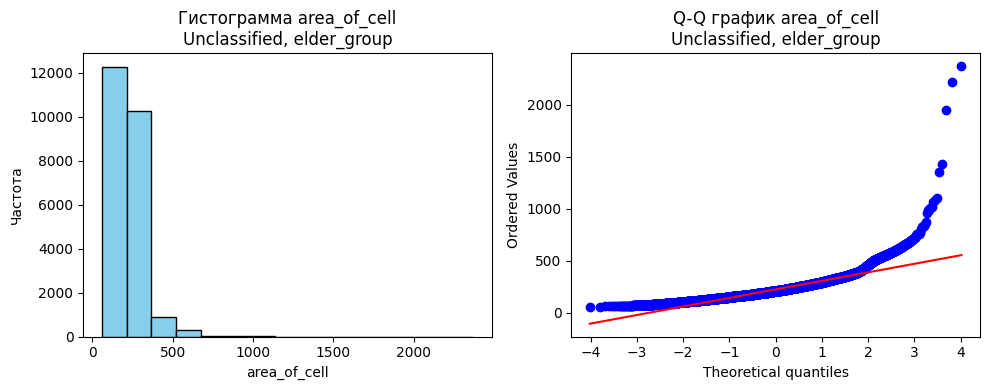


Комбинация: Тип клетки = Unclassified, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.8298444151878357, P-value = 0.0
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


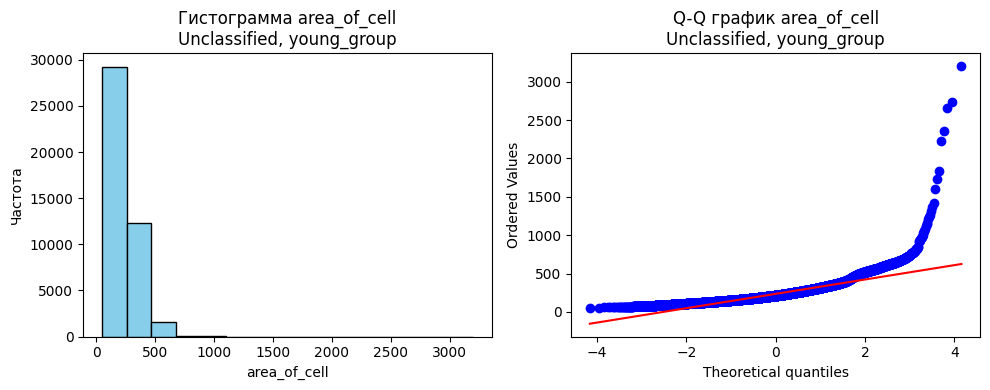


Комбинация: Тип клетки = Vasculature, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.8702884316444397, P-value = 1.8598186102281034e-07
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


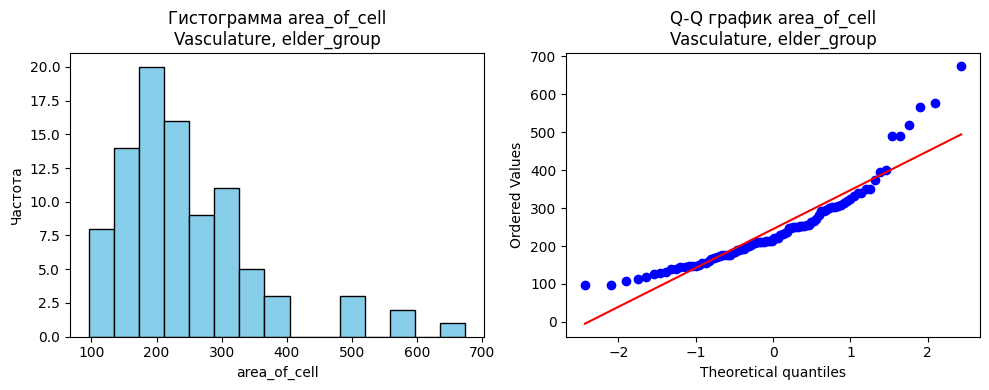


Комбинация: Тип клетки = Vasculature, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.9102335572242737, P-value = 0.0008312473655678332
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


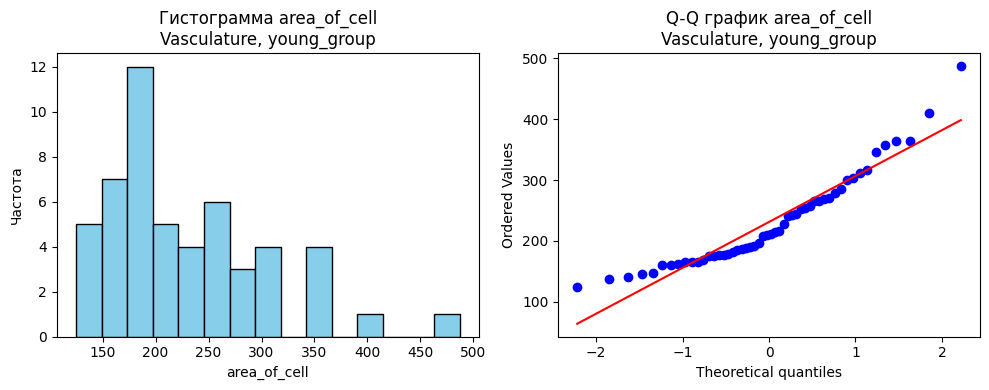

In [ ]:
shapiro_wilk_test_visualization(data, 'area_of_cell')

# Критерий Краскела-Уоллиса
Для оценки статистической значимости в каждой группе, учитывая что данные распределены не нормально, можно использовать непараметрический тест, такой как критерий Краскела-Уоллиса

 Ссылка на документацию: [scipy.stats.kruskal](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html)


Для оценки величины эффектов посчитаем ранговый бисериальный корреляционный коэффициент для непараметрических данных.

Ранговый бисериальный корреляционный коэффициент — это мера силы и направления связи между двумя переменными в случаях, когда одна или обе переменные являются ранговыми.

`H0`:  С возрастом размер клеток не изменяется

`H1`:  С возрастом клетки меняют свой размер

In [ ]:
# @title Тест Критерий Краскела-Уоллиса + Ранговый бисериальный корреляционный коэффициент

# Оценка значимости и величины эффектов
def rank_biserial_effect_size(group1, group2):
    """Расчет рангового бисериального корреляционного коэффициента."""
    all_data = np.concatenate([group1, group2])
    ranks = stats.rankdata(all_data)
    n1, n2 = len(group1), len(group2)
    average_rank_n1 = np.mean(ranks[:n1])
    average_rank_n2 = np.mean(ranks[n1:])
    return (average_rank_n1 - average_rank_n2) / np.max([n1, n2])

def analyze_cell_types(data, column_name, alpha=0.05):
    """Анализирует данные по типам клеток, сравнивая возрастные группы на основе признака column_name.

    Args:
        data (pd.DataFrame): DataFrame содержащий столбцы 'cell_type', 'age_group' и 'area_of_cell'.
    """
    # Получение уникальных типов клеток
    cell_types = data['cell_type'].unique()

    # Проходим по каждому типу клеток и проверяем различия между возрастными группами
    for cell_type in cell_types:
        # Фильтруем данные для текущего типа клеток
        cell_data = data[data['cell_type'] == cell_type]

        # Группируем по возрастной группе и извлекаем площадь клеток
        groups = [group[column_name].values for name, group in cell_data.groupby('age_group') if len(group) > 1]

        # Проводим тест Краскела-Уоллиса, если есть более одной группы
        if len(groups) > 1:
            stat, p_value = stats.kruskal(*groups)
            print(f'\nТип клетки = {cell_type}')
            print(f'Критерий Краскела-Уоллиса: Статистика = {stat}, P-value = {p_value}')

            effect_size = rank_biserial_effect_size(*groups)
            print(f'Ранговый бисериальный корреляционный коэффициент = {effect_size}')

            # Интерпретация результатов
            if p_value > alpha:
                print('Нет статистически значимых различий между возрастными группами. (Принимаем H0)')
            else:
                print('Есть статистически значимые различия между возрастными группами. (Отвергаем H0. Принимаем H1)')

                if abs(effect_size) < 0.1:
                    print('Очень маленький эффект.')
                elif abs(effect_size) < 0.3:
                    print('Маленький эффект.')
                elif abs(effect_size) < 0.5:
                    print('Средний эффект.')
                else:
                    print('Большой эффект.')
        else:
            print(f'\nТип клетки = {cell_type} не имеет достаточно групп для анализа.')


In [ ]:
analyze_cell_types(data, 'area_of_cell')


Тип клетки = Stroma cells
Критерий Краскела-Уоллиса: Статистика = 485.084501150798, P-value = 1.6725518119512272e-107
Ранговый бисериальный корреляционный коэффициент = -0.04709283601454522
Есть статистически значимые различия между возрастными группами. (Отвергаем H0. Принимаем H1)
Очень маленький эффект.

Тип клетки = Unclassified
Критерий Краскела-Уоллиса: Статистика = 51.74215418952049, P-value = 6.328922569995752e-13
Ранговый бисериальный корреляционный коэффициент = -0.025985045592999464
Есть статистически значимые различия между возрастными группами. (Отвергаем H0. Принимаем H1)
Очень маленький эффект.

Тип клетки = Immune type 2
Критерий Краскела-Уоллиса: Статистика = 66.75509052845293, P-value = 3.0742252797501433e-16
Ранговый бисериальный корреляционный коэффициент = 0.06960169443127348
Есть статистически значимые различия между возрастными группами. (Отвергаем H0. Принимаем H1)
Очень маленький эффект.

Тип клетки = Blood cells
Критерий Краскела-Уоллиса: Статистика = 0.06307

##Результаты анализа и выводы

Статистически значимые различия в размере клеток между возрастными группами были обнаружены в таких типах клеток, как «Stroma cells», «Unclassified», «Immune type 1», «Immune type 2», «Bone cells» и «Largest cells». Тем не менее, несмотря на наличие статистической значимости, наблюдаемые различия имеют скромную величину эффекта. Это свидетельствует о том, что практическая значимость этих различий может быть ограниченной.

Тип клеток «Largest cells» выделяется среди других, демонстрируя не только статистически значимые различия, но и более выраженную величину эффекта. Это указывает на наличие более значительных практических различий в размере клеток между возрастными группами для этого типа клеток в сравнении с остальными.

В то же время, для клеток типов «Blood cells» и «Vasculature» не было обнаружено статистически значимых различий в размере клеток между возрастными группами. Это означает, что размер клеток этих типов, по-видимому, не подвержен значимым изменениям с возрастом.

Таким образом, возраст может оказывать влияние на размер определенных типов клеток, в частности, на «Stroma cells», «Unclassified», «Immune type 1», «Immune type 2» и «Bone cells», и особенно заметно влияет на «Largest cells». Однако такое влияние не распространяется на клетки крови и кровеносные сосуды («Blood cells» и «Vasculature»), размер которых остается ботносительно стабильным вне зависимости от возраста.







# Задача 1.б
Есть ли стат-значимость между типом клетки и экспрессией иммунных маркеров (`immune_marker_1`, `immune_marker_2`), добавьте hue по возрастным группам.

В качестве ответов можно приводить box_plot/swarplot, где по одной оси будет тип клеток, а по другой — оцениваемая вами статистика.



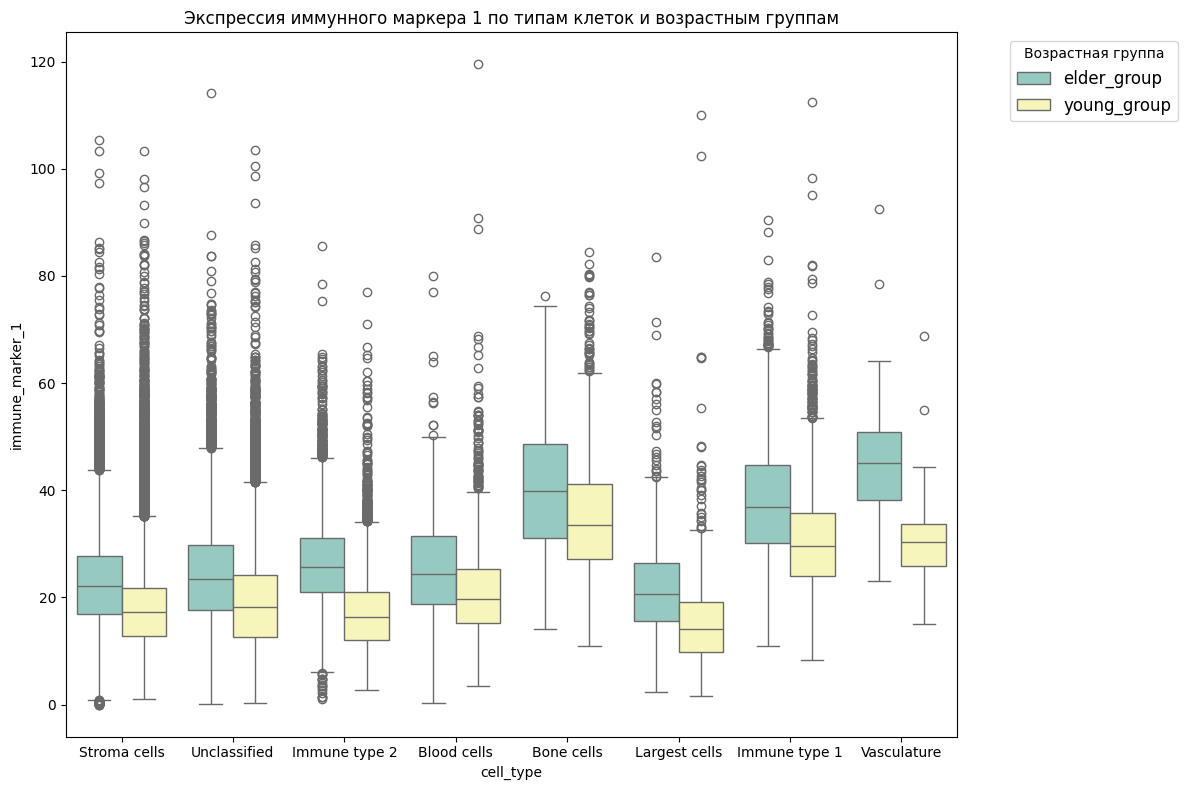

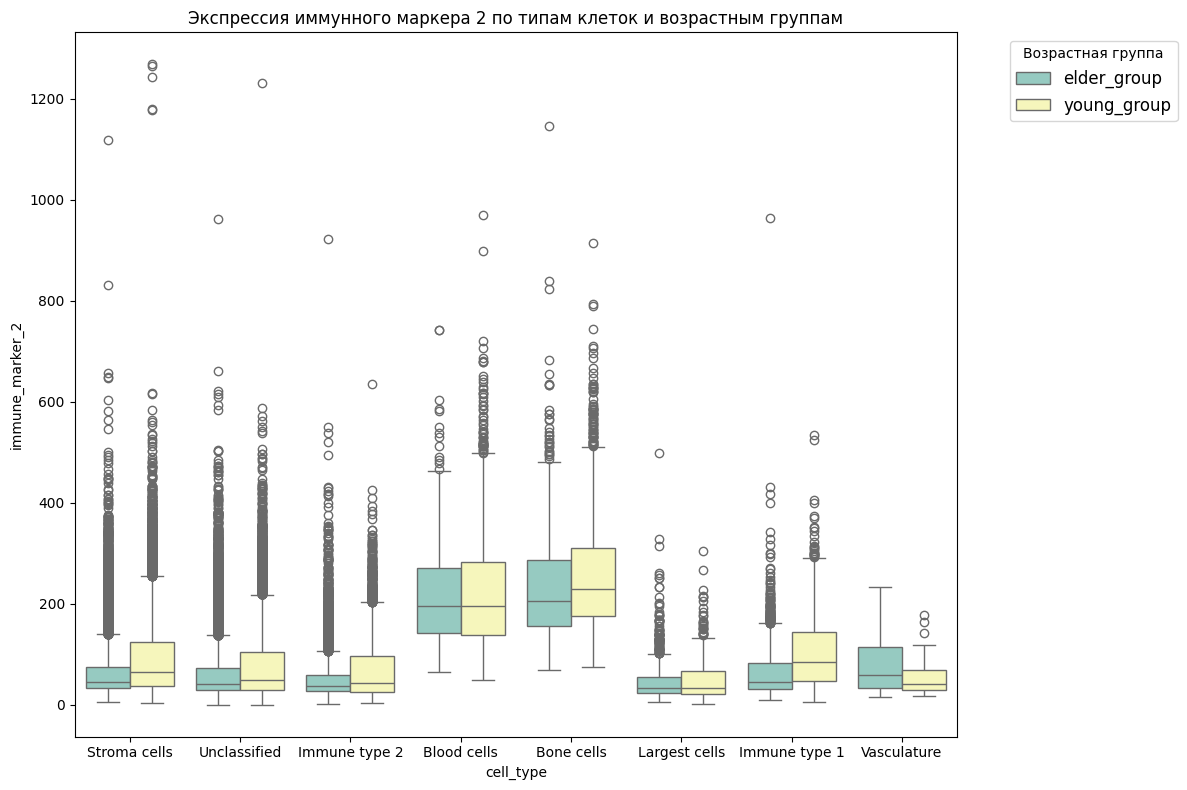

In [ ]:
# Визуализация экспрессии иммунного маркера 1
plt.figure(figsize=(12, 8))
sns.boxplot(x='cell_type', y='immune_marker_1', hue='age_group', data=data, palette="Set3")
plt.title('Экспрессия иммунного маркера 1 по типам клеток и возрастным группам')
plt.legend(title='Возрастная группа', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

# Визуализация экспрессии иммунного маркера 2
plt.figure(figsize=(12, 8))
sns.boxplot(x='cell_type', y='immune_marker_2', hue='age_group', data=data, palette="Set3")
plt.title('Экспрессия иммунного маркера 2 по типам клеток и возрастным группам')
plt.legend(title='Возрастная группа', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

###Экспрессия иммунного маркера 1:

Разброс значений маркера существенно отличается в зависимости от типа клеток. Можно сделать предположение о наличии различий в экспрессии иммунного маркера 1 между возрастными группами для разных типов клеток, но для утверждения о статистической значимости необходимо провести статистические тесты



###Экспрессия иммунного маркера 2:

В целом, уровни экспрессии этого маркера значительно выше, чем у первого маркера. В данном случае, также видны вариации в уровнях экспрессии маркера между типами клеток, однако различия для кажого типа клеток в отдельности между возрастными группами менее выражены.



Комбинация: Тип клетки = Blood cells, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.9432292580604553, P-value = 3.177288347786661e-13
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


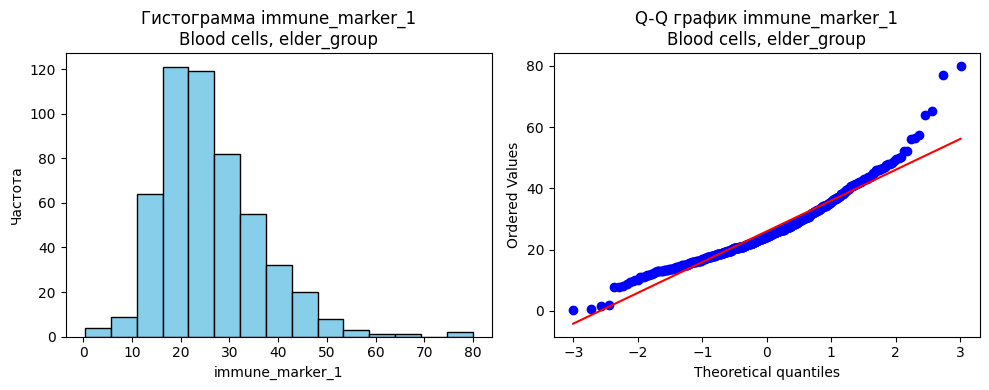


Комбинация: Тип клетки = Blood cells, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.8889740705490112, P-value = 8.357735283764448e-38
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


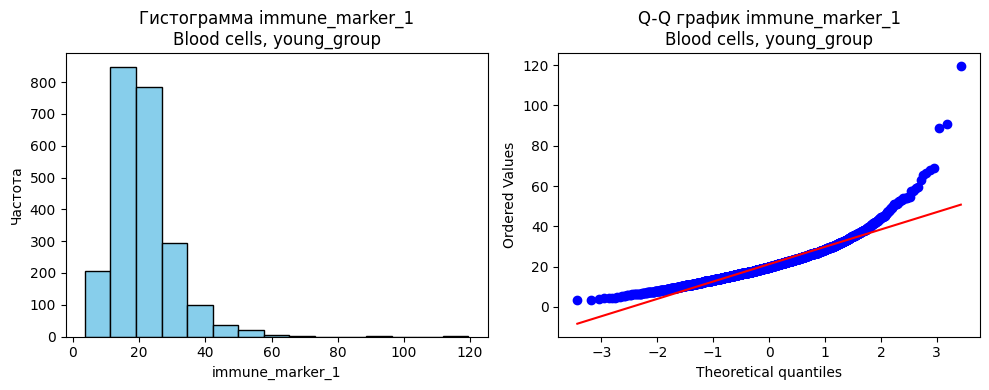


Комбинация: Тип клетки = Bone cells, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.9928882718086243, P-value = 0.06075022742152214
Данные соответсвуют нормальному распределению. (Принимаем H0)


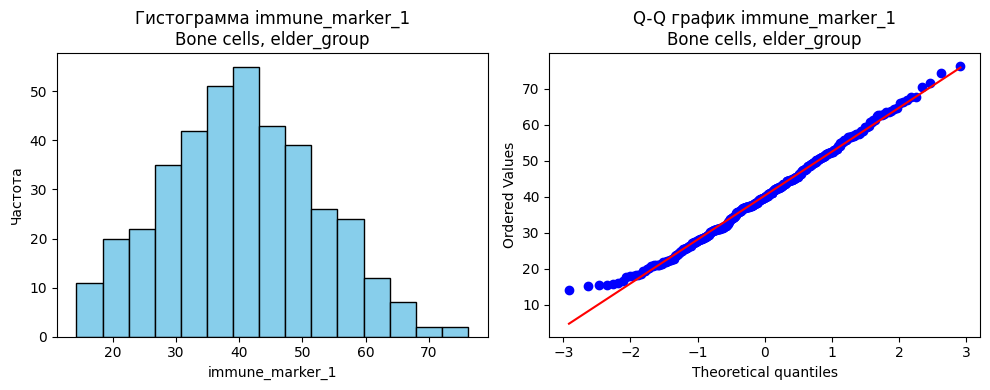


Комбинация: Тип клетки = Bone cells, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.9612439274787903, P-value = 1.2873990669875261e-23
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


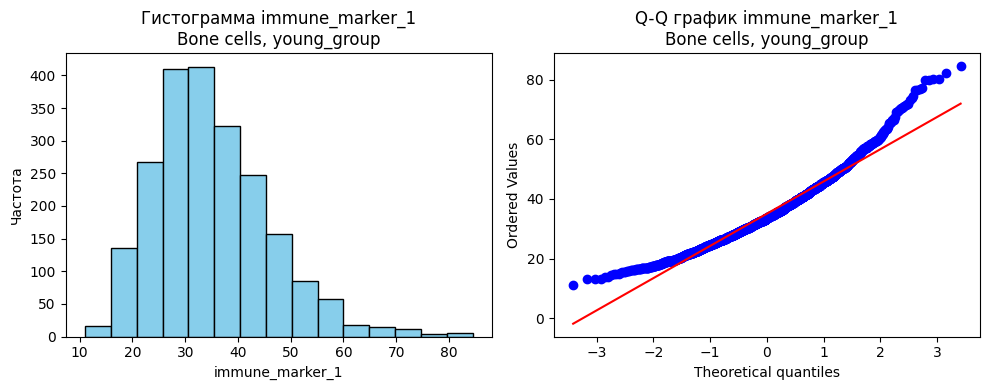


Комбинация: Тип клетки = Immune type 1, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.9684225916862488, P-value = 4.0130754271974456e-18
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


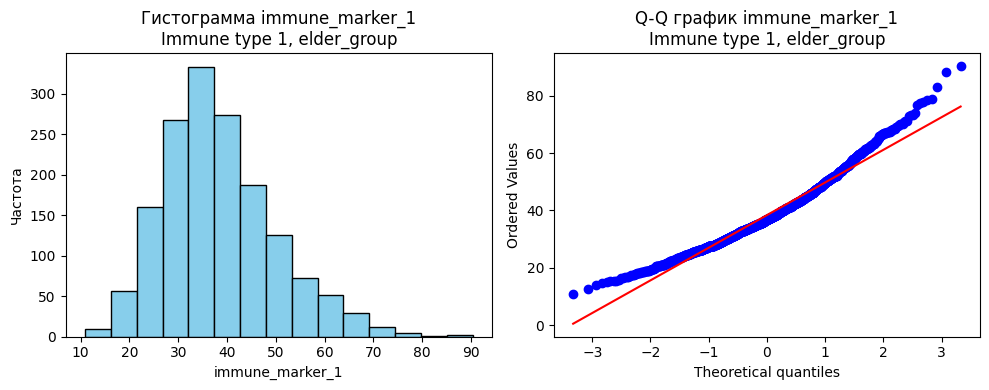


Комбинация: Тип клетки = Immune type 1, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.9540300369262695, P-value = 1.0294996973245864e-33
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


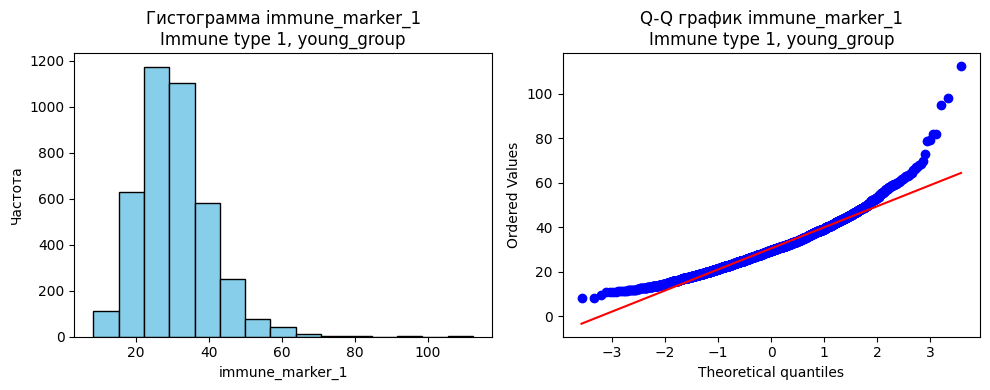

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Комбинация: Тип клетки = Immune type 2, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.9711366295814514, P-value = 2.0050237605040273e-36
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


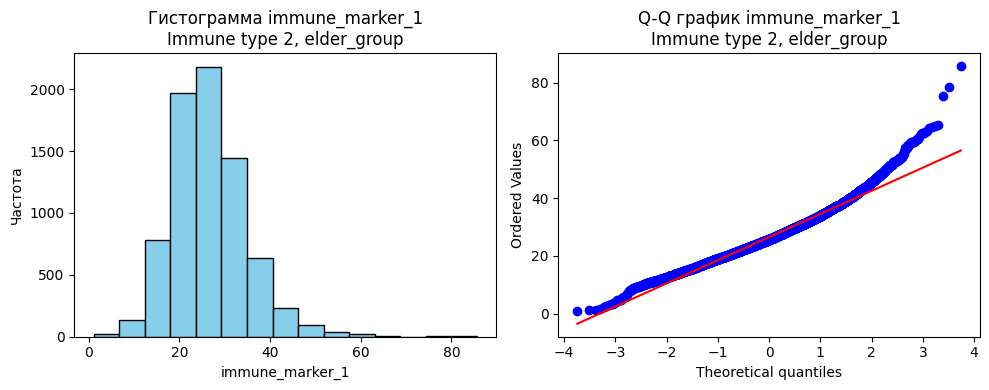


Комбинация: Тип клетки = Immune type 2, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.9378294944763184, P-value = 0.0
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


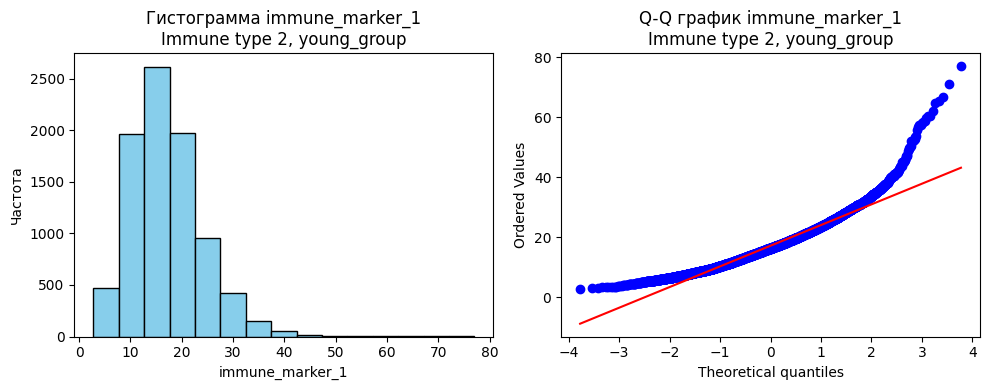


Комбинация: Тип клетки = Largest cells, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.8976133465766907, P-value = 9.576376958930473e-24
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


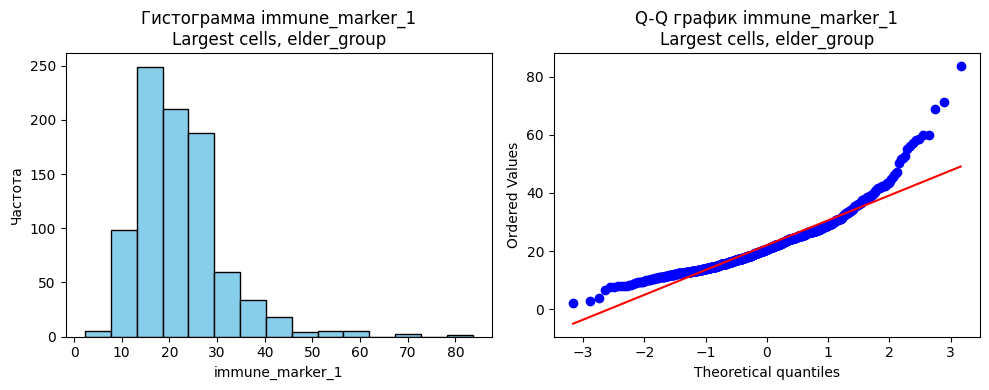


Комбинация: Тип клетки = Largest cells, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.8016563653945923, P-value = 9.112782330403475e-35
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


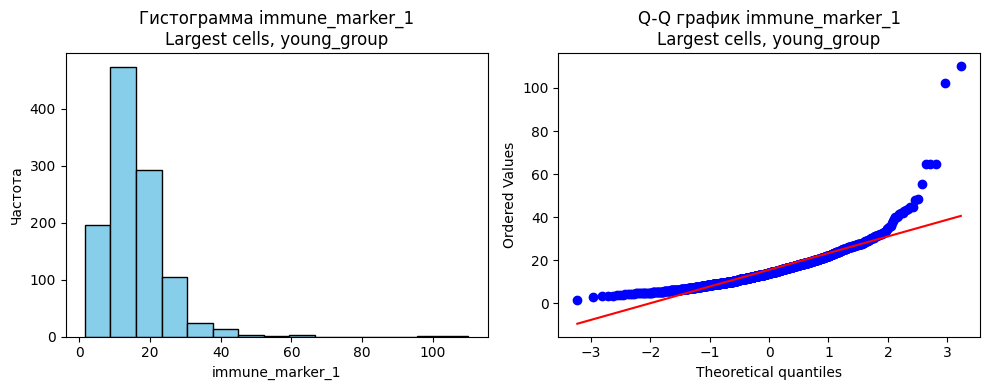


Комбинация: Тип клетки = Stroma cells, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.9728595614433289, P-value = 0.0
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


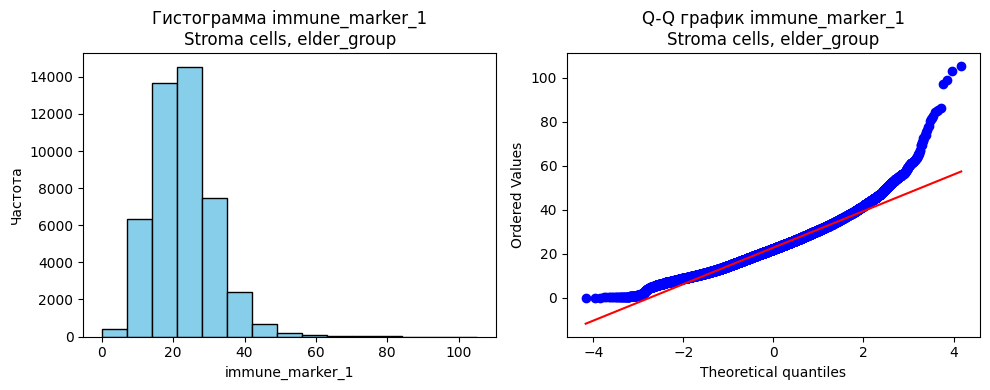


Комбинация: Тип клетки = Stroma cells, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.953441858291626, P-value = 0.0
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


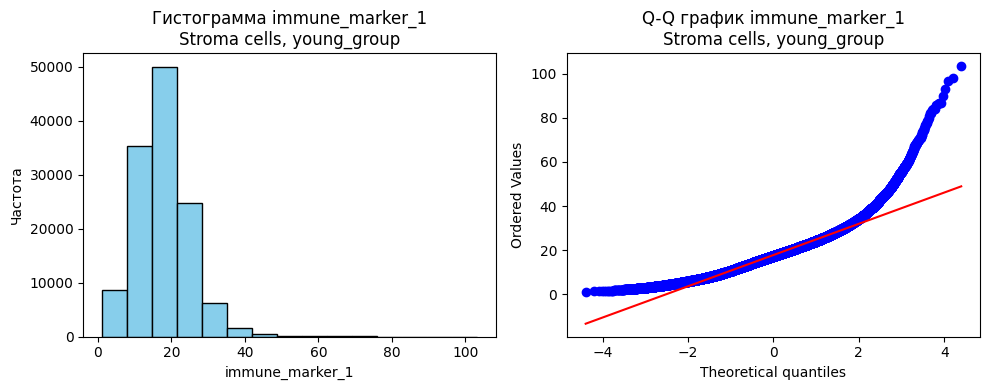


Комбинация: Тип клетки = Unclassified, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.9760130643844604, P-value = 0.0
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


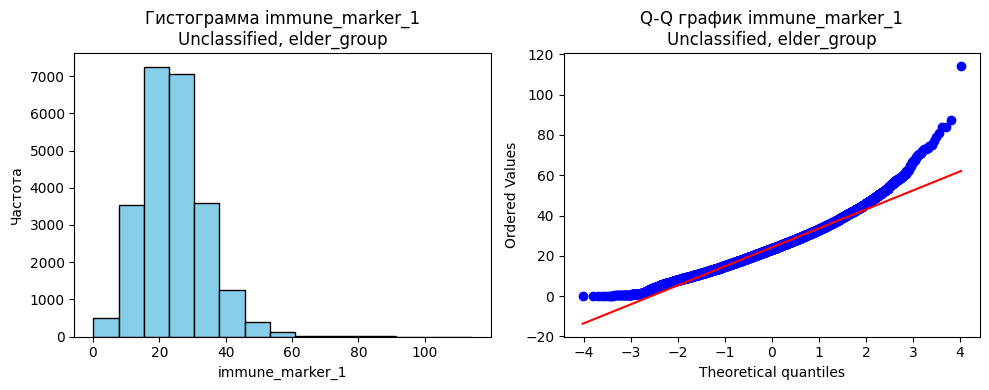


Комбинация: Тип клетки = Unclassified, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.9608532190322876, P-value = 0.0
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


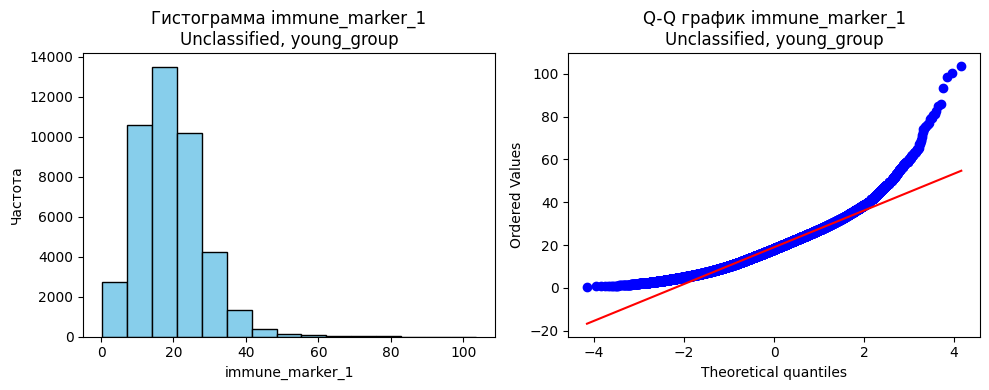


Комбинация: Тип клетки = Vasculature, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.9423597455024719, P-value = 0.0004979102523066103
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


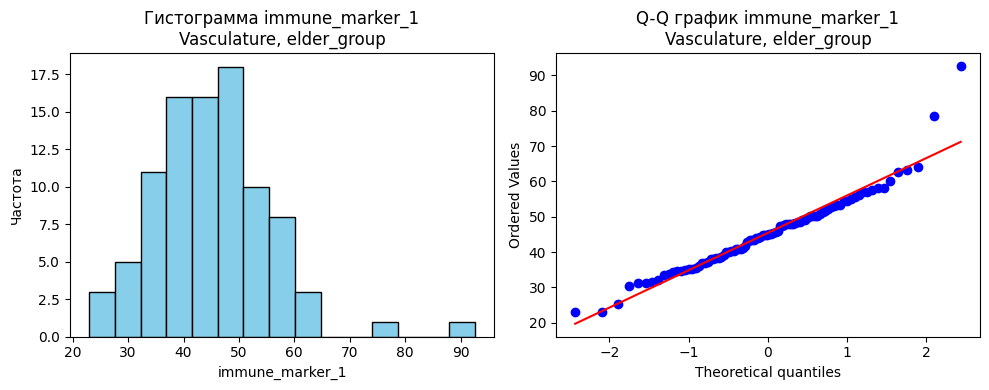


Комбинация: Тип клетки = Vasculature, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.8686671853065491, P-value = 3.7773435906274244e-05
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


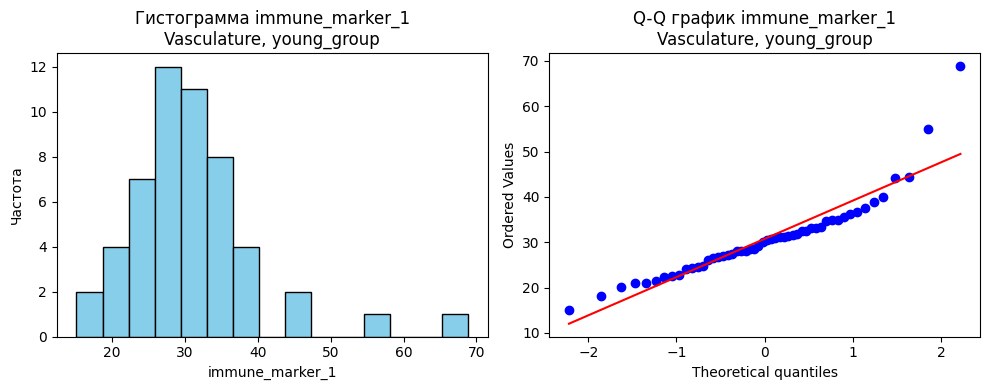

In [ ]:
# @title Тест Шапиро-Уилка для иммуномаркера 1
shapiro_wilk_test_visualization(data, 'immune_marker_1')


Комбинация: Тип клетки = Blood cells, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.901827335357666, P-value = 8.571230618023447e-18
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


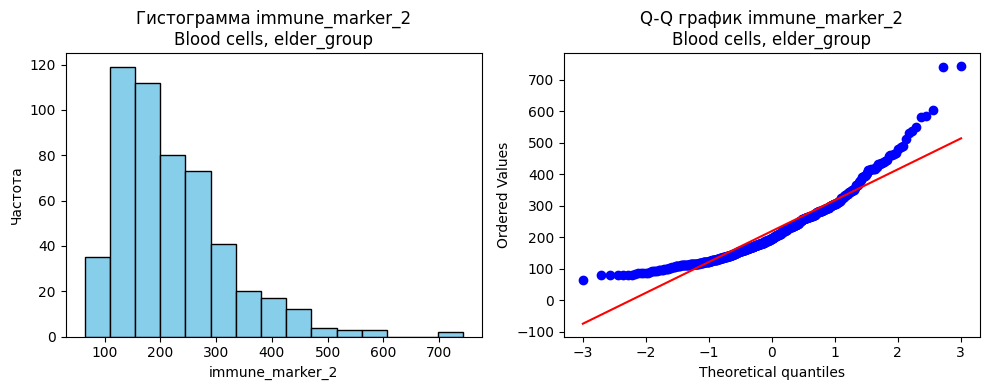


Комбинация: Тип клетки = Blood cells, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.9161286354064941, P-value = 6.619350116144384e-34
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


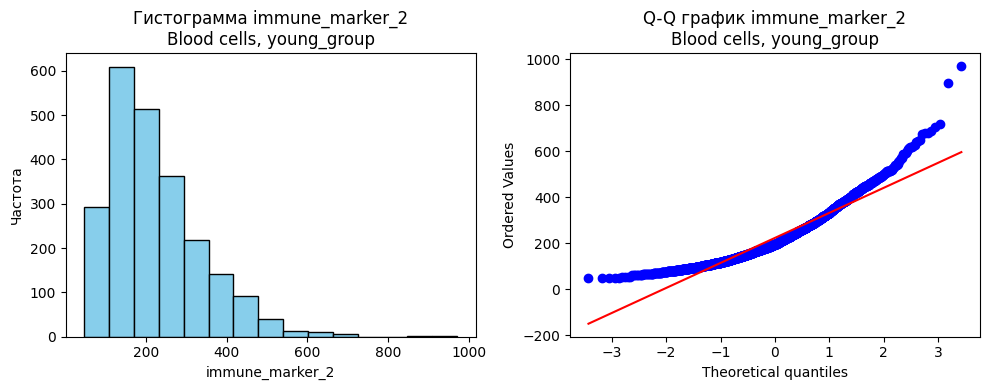


Комбинация: Тип клетки = Bone cells, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.8315079212188721, P-value = 5.848514605101119e-20
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


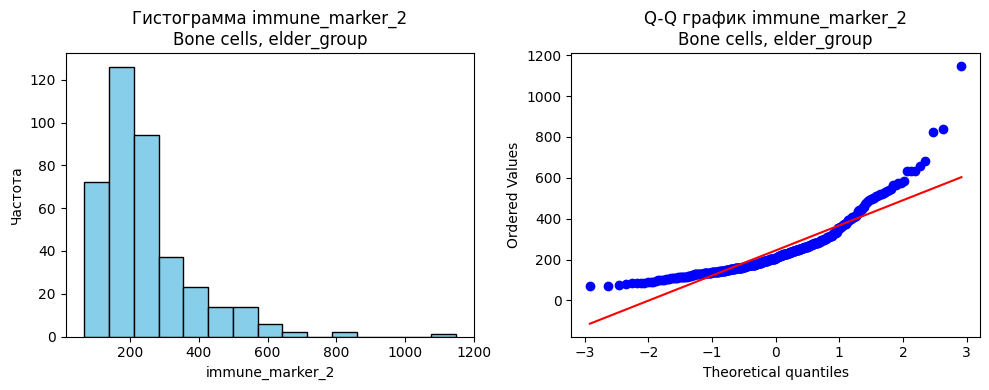


Комбинация: Тип клетки = Bone cells, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.9141331315040588, P-value = 2.335467584438913e-33
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


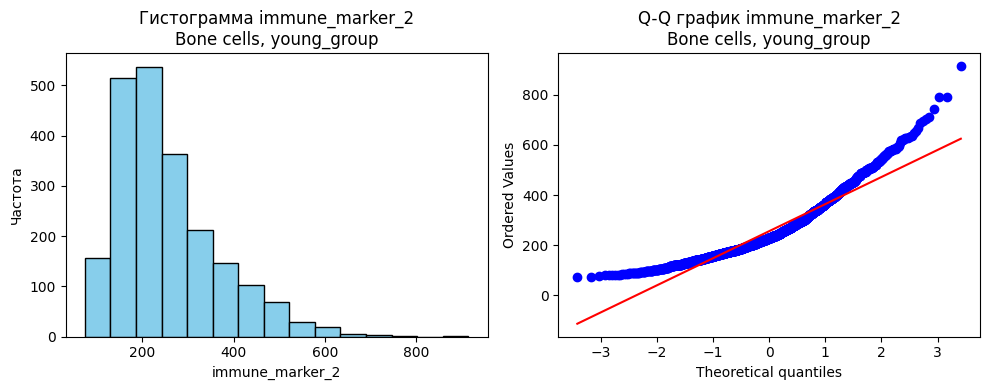


Комбинация: Тип клетки = Immune type 1, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.7075138092041016, P-value = 0.0
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


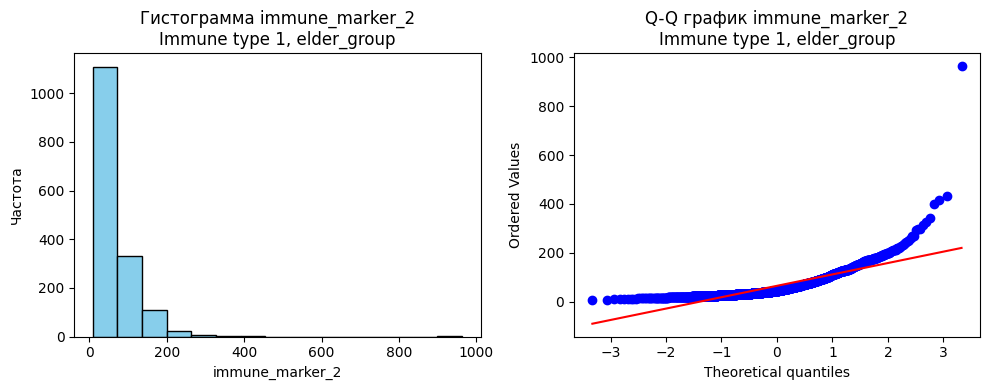


Комбинация: Тип клетки = Immune type 1, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.9273234605789185, P-value = 2.6355901776714024e-40
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


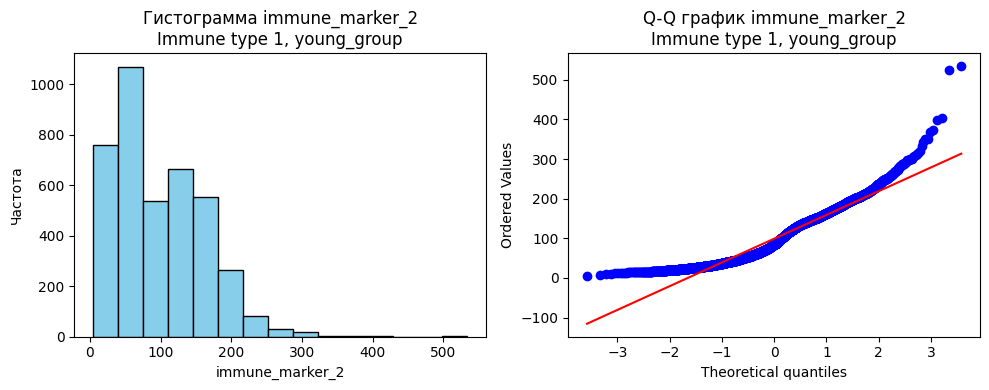

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Комбинация: Тип клетки = Immune type 2, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.6652328968048096, P-value = 0.0
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


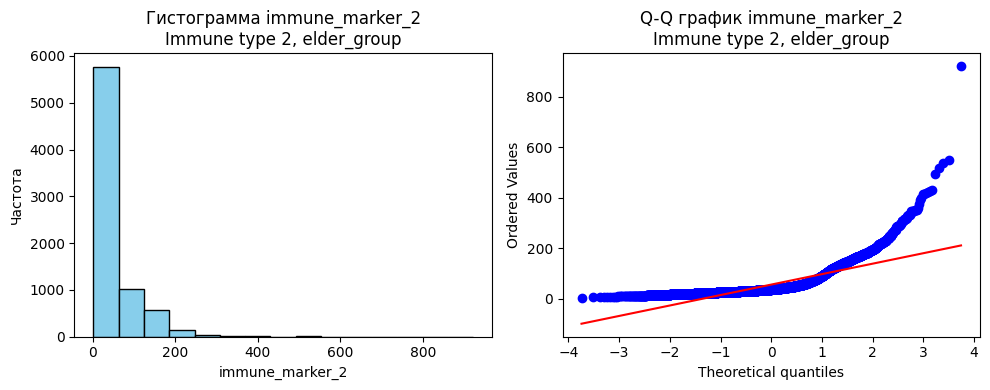


Комбинация: Тип клетки = Immune type 2, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.8236071467399597, P-value = 0.0
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


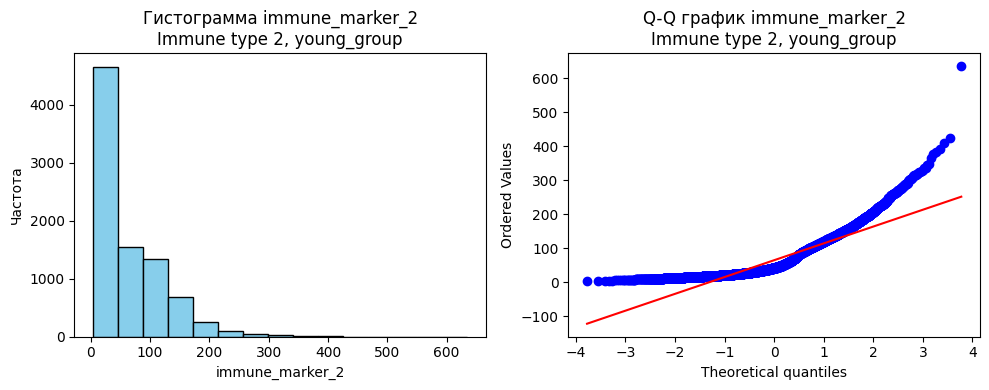


Комбинация: Тип клетки = Largest cells, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.6852682828903198, P-value = 1.6934869065491305e-37
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


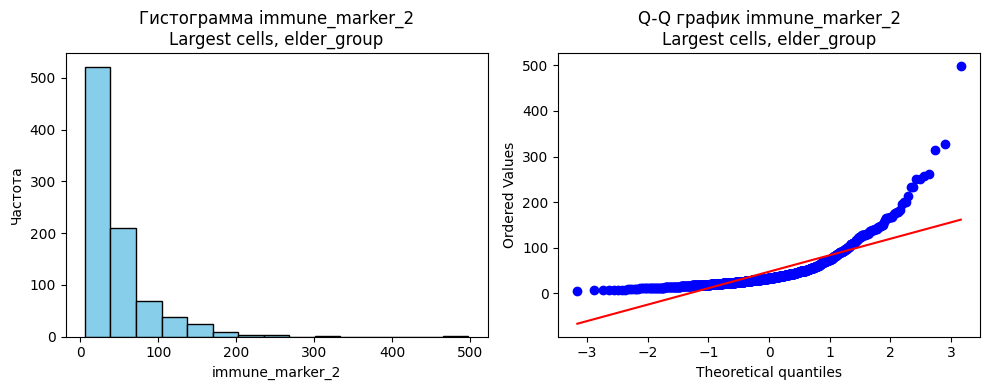


Комбинация: Тип клетки = Largest cells, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.8466029167175293, P-value = 1.9582372311252356e-31
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


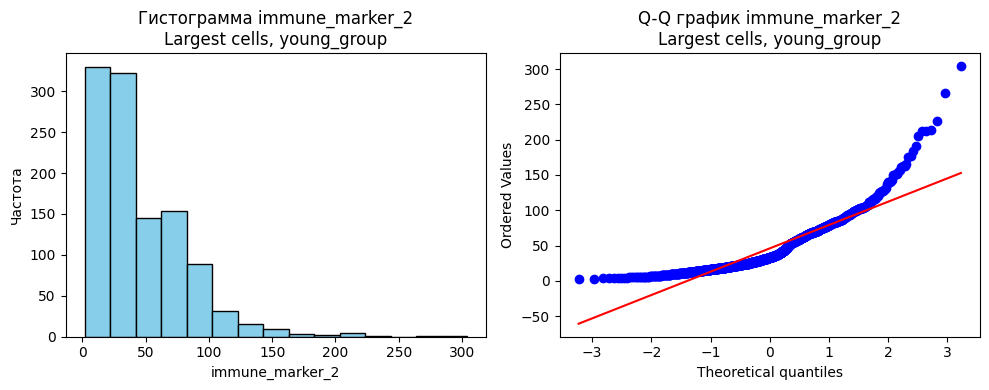


Комбинация: Тип клетки = Stroma cells, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.7431447505950928, P-value = 0.0
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


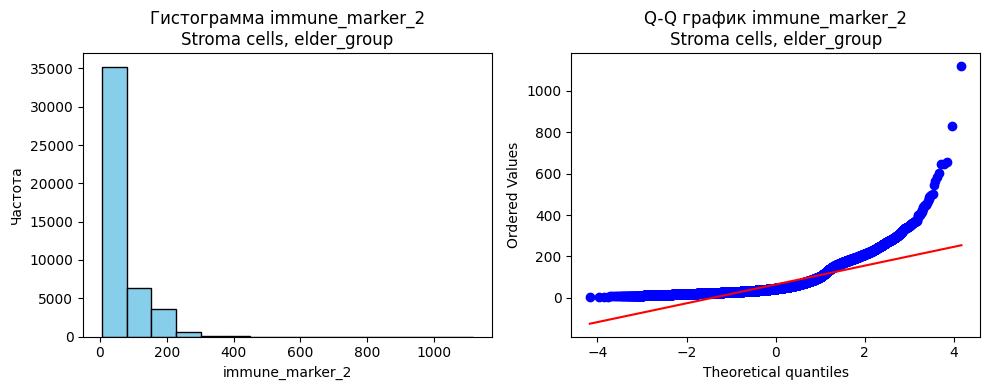


Комбинация: Тип клетки = Stroma cells, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.894053041934967, P-value = 0.0
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


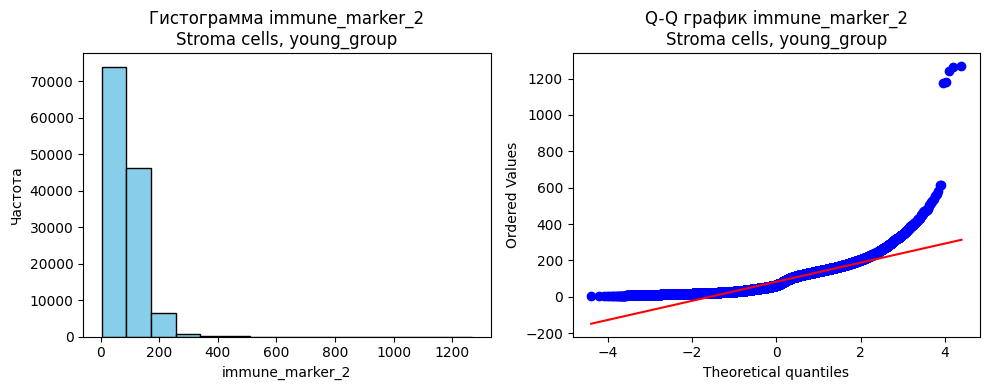


Комбинация: Тип клетки = Unclassified, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.72622150182724, P-value = 0.0
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


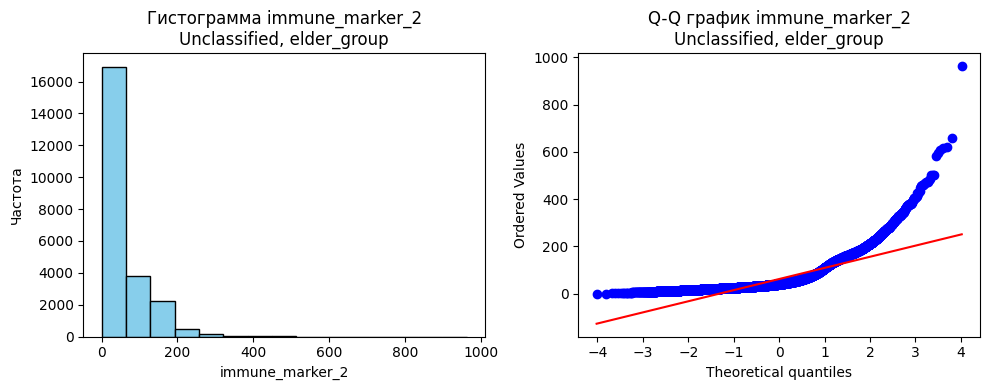


Комбинация: Тип клетки = Unclassified, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.8350111842155457, P-value = 0.0
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


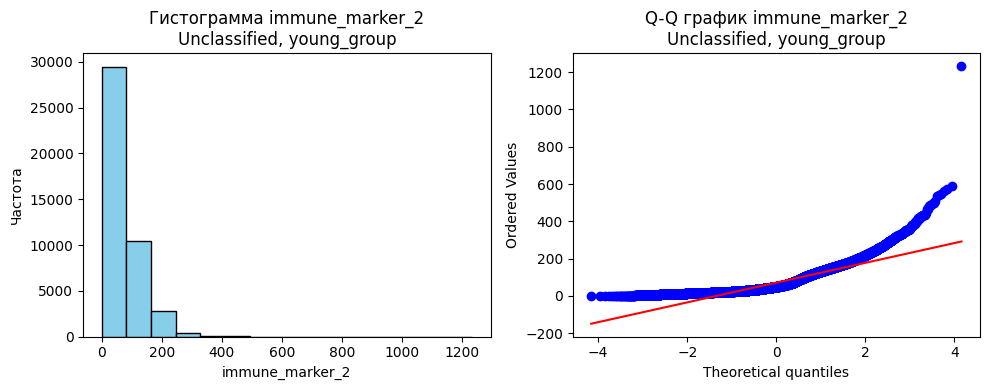


Комбинация: Тип клетки = Vasculature, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.8913481831550598, P-value = 1.3556879139287048e-06
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


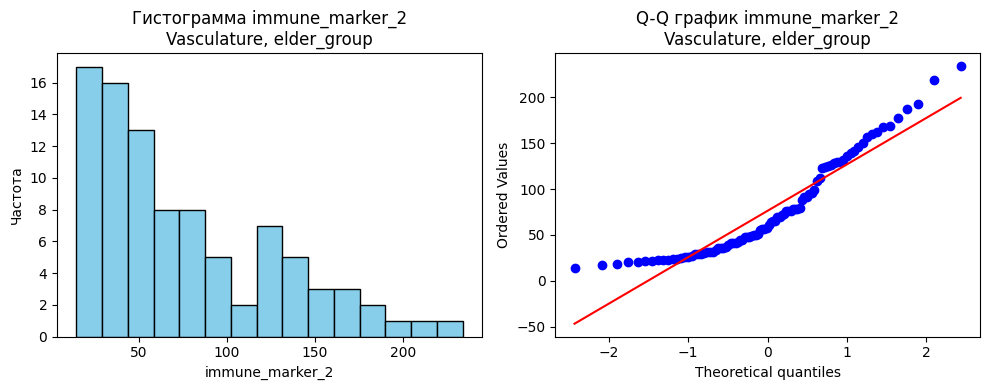


Комбинация: Тип клетки = Vasculature, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.8181174993515015, P-value = 1.6265995554931578e-06
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


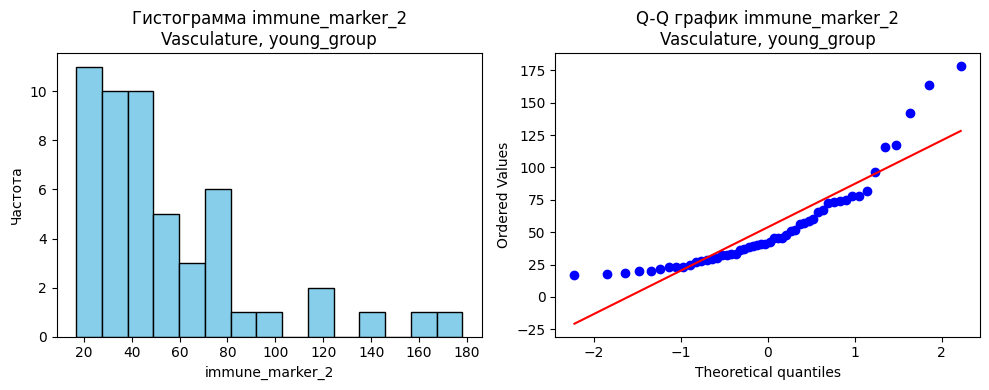

In [ ]:
# @title Тест Шапиро-Уилка для иммуномаркера 2
shapiro_wilk_test_visualization(data, 'immune_marker_2')

Так как для всех групп, кроме костных клеток в старшей группе для иммуномаркера 1, распределение отлично от нормального, будем использовать непараметрический тест "Критерий Краскела-Уоллиса "

`H0`:  С возрастом экспрессия иммунных маркеров не изменяется

`H1`:  Возраст влияет на экспрессию иммунных маркеров

In [ ]:
# @title Тест Критерий Краскела-Уоллиса + Ранговый бисериальный корреляционный коэффициент для иммуномаркера 1
analyze_cell_types(data, 'immune_marker_1')


Тип клетки = Stroma cells
Критерий Краскела-Уоллиса: Статистика = 13098.31611082594, P-value = 0.0
Ранговый бисериальный корреляционный коэффициент = 0.24471364819202035
Есть статистически значимые различия между возрастными группами. (Отвергаем H0. Принимаем H1)
Маленький эффект.

Тип клетки = Unclassified
Критерий Краскела-Уоллиса: Статистика = 4934.931297609051, P-value = 0.0
Ранговый бисериальный корреляционный коэффициент = 0.25377402767399965
Есть статистически значимые различия между возрастными группами. (Отвергаем H0. Принимаем H1)
Маленький эффект.

Тип клетки = Immune type 2
Критерий Краскела-Уоллиса: Статистика = 5095.50181617559, P-value = 0.0
Ранговый бисериальный корреляционный коэффициент = 0.6081023893984658
Есть статистически значимые различия между возрастными группами. (Отвергаем H0. Принимаем H1)
Большой эффект.

Тип клетки = Blood cells
Критерий Краскела-Уоллиса: Статистика = 117.91952042664128, P-value = 1.8056797201268765e-27
Ранговый бисериальный корреляционны

##Результаты анализа и выводы
* Для клеток типа "Stroma cells" и "Unclassified", "Blood cells", "Bone cells" и "Immune type 1" наблюдается маленький эффект, но статистически значимые различия в экспрессии иммунного маркера 1 между возрастными группами. Это указывает на то, что возраст может влиять на экспрессию иммунных маркеров в этих типах клеток, но величина эффекта не очень велика.

* Для клеток "Immune type 2" и "Vasculature", статистическая значимость также подтверждается, однако здесь наблюдается большой эффект, что указывает на более значимое влияние возраста на уровни экспрессии в этих клетках.

* Для "Largest cells" результаты также показывают статистически значимые различия с средним эффектом для крупных клеток и клеток "Immune type 1".

В целом, данные указывают на то, что экспрессия иммунного маркера 1 в различных типах клеток изменяется с возрастом, и эти изменения статистически значимы, хотя и с различной величиной эффекта в зависимости от типа клетки.

In [ ]:
# @title Тест Критерий Краскела-Уоллиса + Ранговый бисериальный корреляционный коэффициент для иммуномаркера 2
analyze_cell_types(data, 'immune_marker_2')


Тип клетки = Stroma cells
Критерий Краскела-Уоллиса: Статистика = 4079.329626977957, P-value = 0.0
Ранговый бисериальный корреляционный коэффициент = -0.13656671330626322
Есть статистически значимые различия между возрастными группами. (Отвергаем H0. Принимаем H1)
Маленький эффект.

Тип клетки = Unclassified
Критерий Краскела-Уоллиса: Статистика = 393.78741289033127, P-value = 1.2398323559885132e-87
Ранговый бисериальный корреляционный коэффициент = -0.07168652555181401
Есть статистически значимые различия между возрастными группами. (Отвергаем H0. Принимаем H1)
Очень маленький эффект.

Тип клетки = Immune type 2
Критерий Краскела-Уоллиса: Статистика = 38.67761279254942, P-value = 4.999100708526236e-10
Ранговый бисериальный корреляционный коэффициент = -0.05298013488665223
Есть статистически значимые различия между возрастными группами. (Отвергаем H0. Принимаем H1)
Очень маленький эффект.

Тип клетки = Blood cells
Критерий Краскела-Уоллиса: Статистика = 0.04600950714081011, P-value = 

##Результаты анализа и выводы

* В клетках "Stroma cells" и "Immune type 1" среди разных возрастных групп критерий Краскела-Уоллиса выявил статистически значимые различия с маленьким эффектом. Отрицательный ранговый бисериальный корреляционный коэффициент указывает на то, что с увеличением возраста экспрессия иммунного маркера 2 уменьшается, хотя и не очень сильно.

* Для клеток "Unclassified", "Immune type 2", "Bone cells" также прослеживается статистическая значимость изменений, но влияние возраста на экспрессию маркера выражено весьма слабо.

* Анализ клеток сосудистой системы "Vasculature" выявил статистически значимое, но небольшое увеличение уровня экспрессии иммунного маркера 2 с возрастом, что может отражать возрастные изменения в сосудистой функции

* Однако, в кровяных клетках "Blood cells" и крупных клетках "Largest cells" статистически значимых различий нет, что предполагает стабильность этих показателей независимо от возрастной категории.


Таким образом, можно сказать, что возраст оказывает небольшое влияние на экспрессию иммунного маркера 2 в некоторых типах клеток, но величина этого эффекта мала.

# Задача 1.в

Есть ли стат-значимость между типом клетки и дистанцией до ближайших объектов (`distance_to_vasculature`, `distance_to_largest_cell`), добавьте hue по возрастным группам.

В качестве ответов можно приводить box_plot/swarplot, где по одной оси будет тип клеток, а по другой — оцениваемая вами статистика.

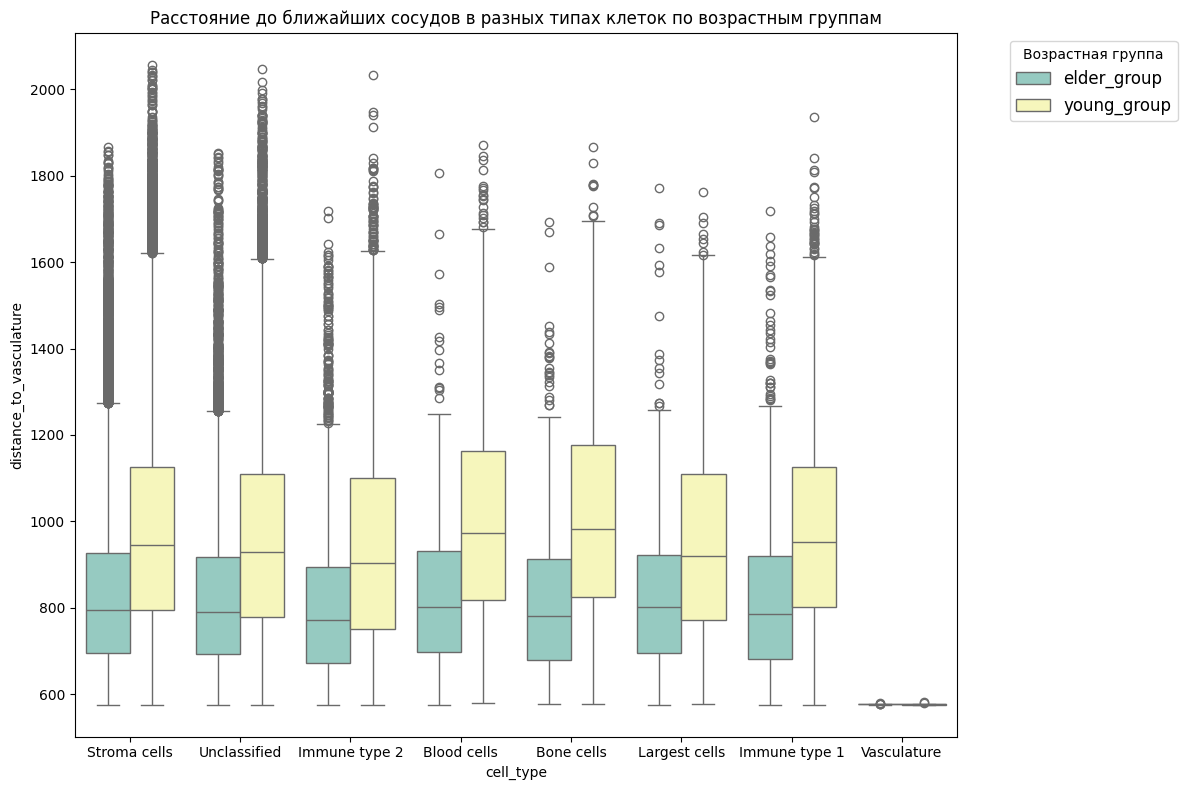

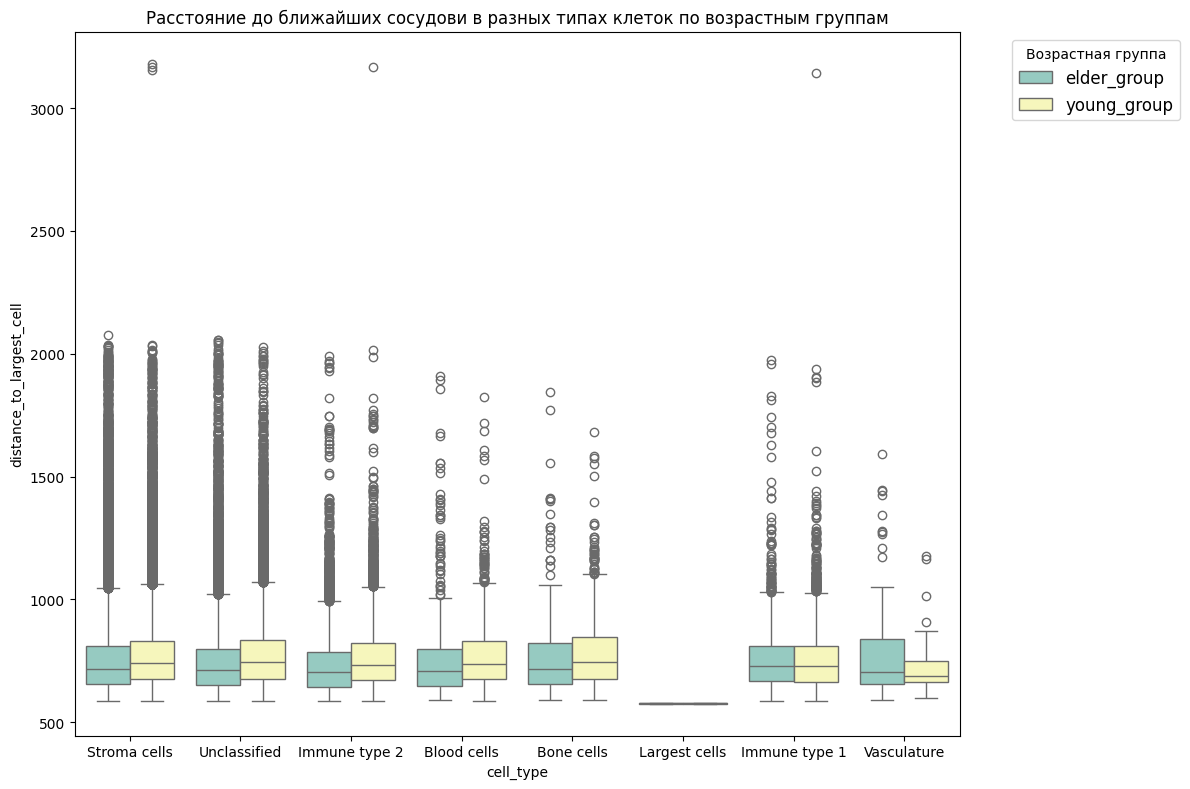

In [ ]:
# Визуализация Расстояние до ближайших сосудов
plt.figure(figsize=(12, 8))
sns.boxplot(x='cell_type', y='distance_to_vasculature', hue='age_group', data=data, palette="Set3")
plt.title('Расстояние до ближайших сосудов в разных типах клеток по возрастным группам')
plt.legend(title='Возрастная группа', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

# Визуализация Расстояние до ближайших крупных клеток
plt.figure(figsize=(12, 8))
sns.boxplot(x='cell_type', y='distance_to_largest_cell', hue='age_group', data=data, palette="Set3")
plt.title('Расстояние до ближайших сосудови в разных типах клеток по возрастным группам')
plt.legend(title='Возрастная группа', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.tight_layout()
plt.tight_layout()
plt.show()



Расстояние до ближайших сосудов и до ближайших крупных клеток оказывается  больше в молодой группе, однако разница в расстоянии до крупных клеток между двумя группами не так выражена, как разница в расстоянии до сосудов. Это может указывать на менее значительное влияние возраста на распределение расстояния до крупных клеток в тканях по сравнению с расположением ближайших сосудов.


Комбинация: Тип клетки = Blood cells, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.9112358689308167, P-value = 6.750849942638814e-17
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


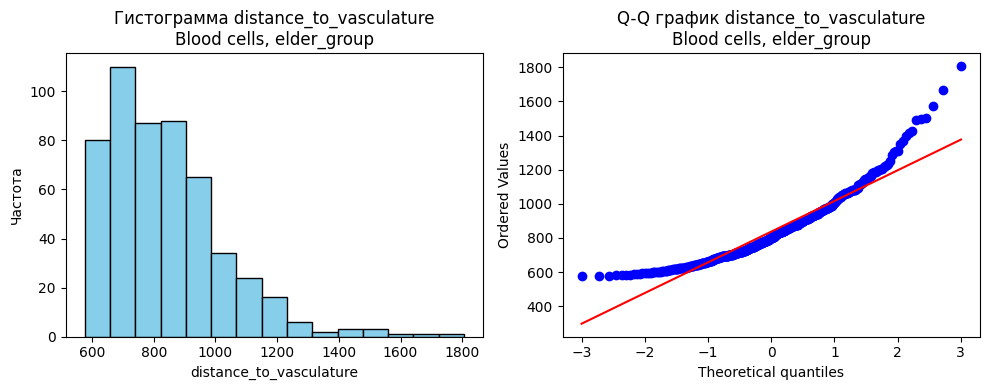


Комбинация: Тип клетки = Blood cells, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.9680377244949341, P-value = 3.4532344474193996e-22
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


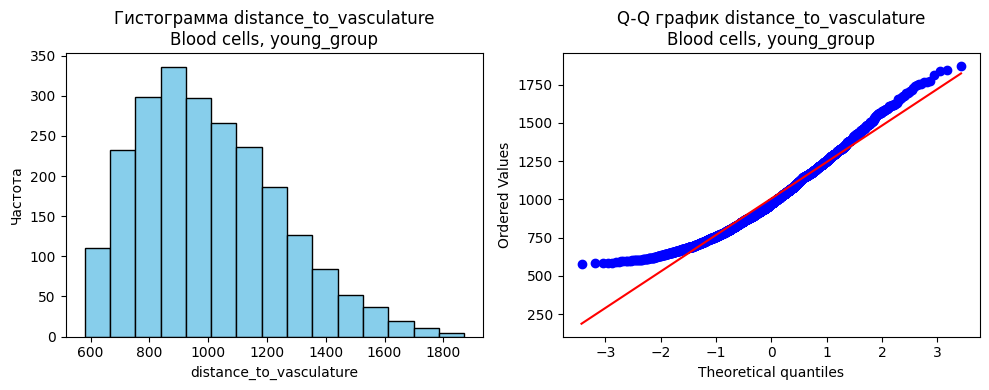


Комбинация: Тип клетки = Bone cells, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.8820671439170837, P-value = 9.85297907178213e-17
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


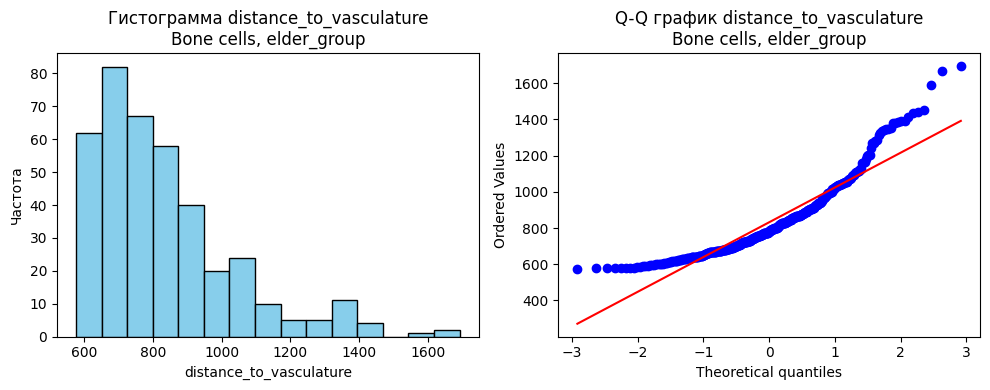


Комбинация: Тип клетки = Bone cells, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.9753723740577698, P-value = 7.396429834586847e-19
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


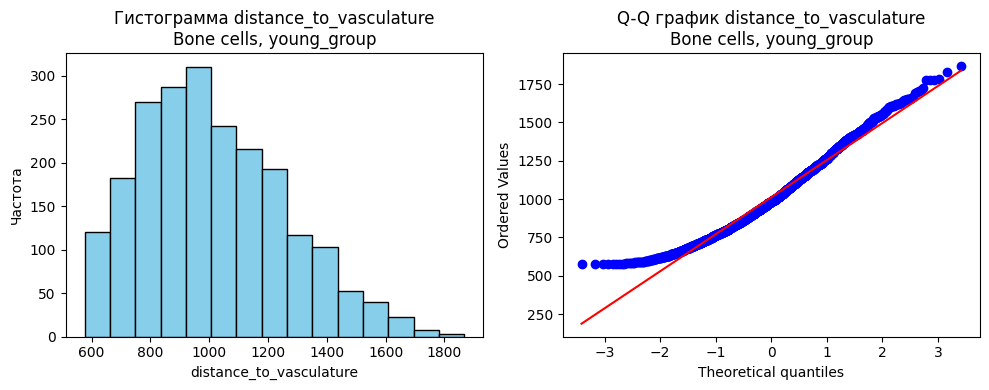


Комбинация: Тип клетки = Immune type 1, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.9207243919372559, P-value = 4.605305831213119e-28
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


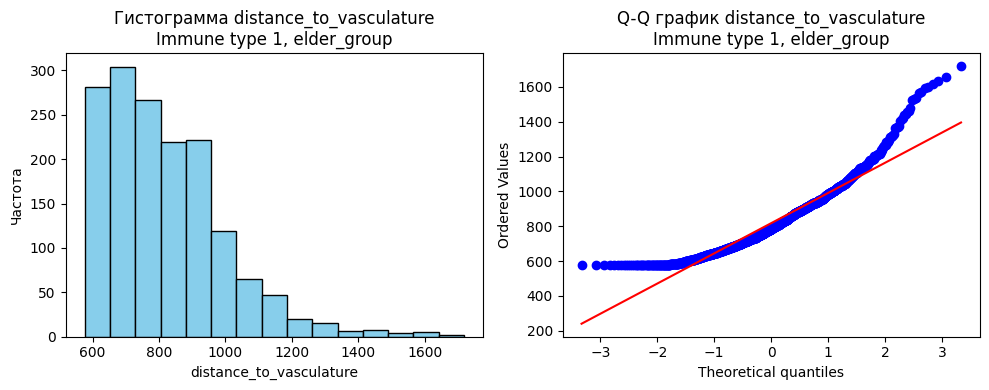


Комбинация: Тип клетки = Immune type 1, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.9729354977607727, P-value = 7.425057744267532e-27
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


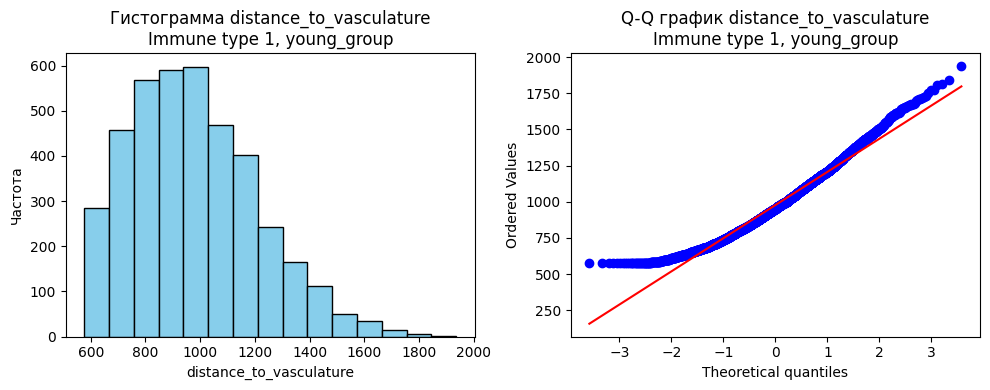

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Комбинация: Тип клетки = Immune type 2, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.9209381937980652, P-value = 0.0
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


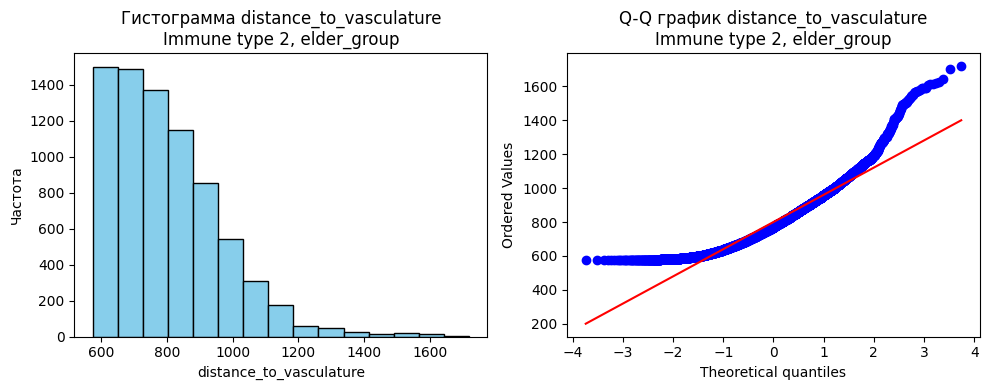


Комбинация: Тип клетки = Immune type 2, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.9553380608558655, P-value = 2.802596928649634e-45
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


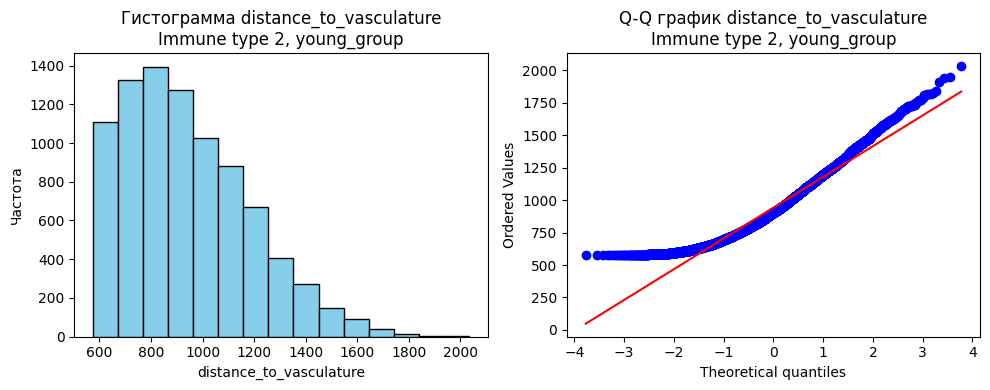


Комбинация: Тип клетки = Largest cells, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.9214195609092712, P-value = 5.52454140181777e-21
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


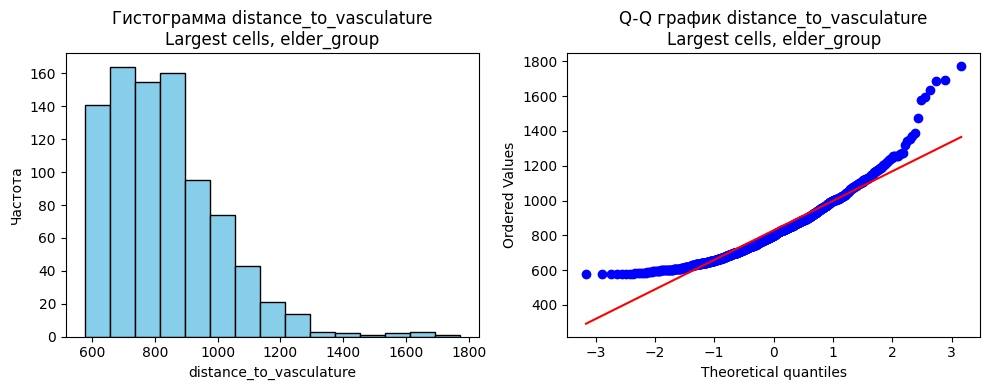


Комбинация: Тип клетки = Largest cells, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.9667357206344604, P-value = 3.019270963344582e-15
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


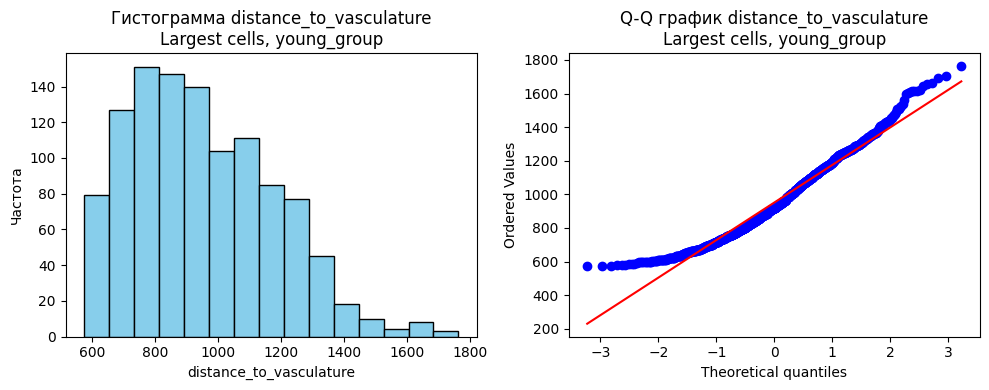


Комбинация: Тип клетки = Stroma cells, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.9098826050758362, P-value = 0.0
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


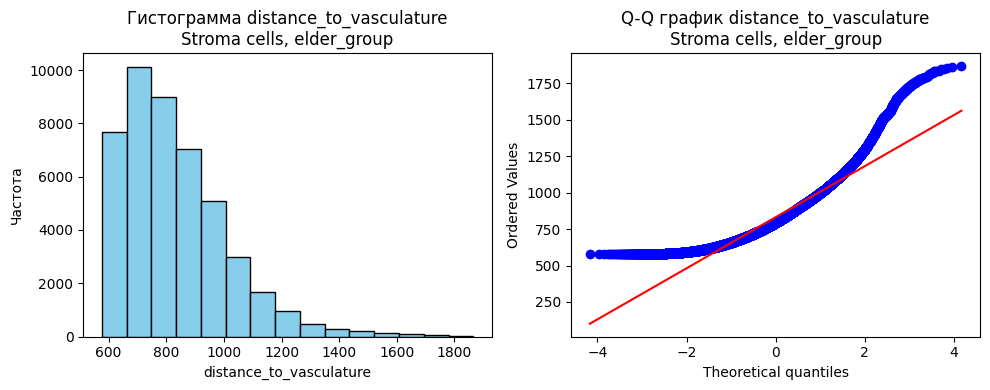


Комбинация: Тип клетки = Stroma cells, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.9650185108184814, P-value = 0.0
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


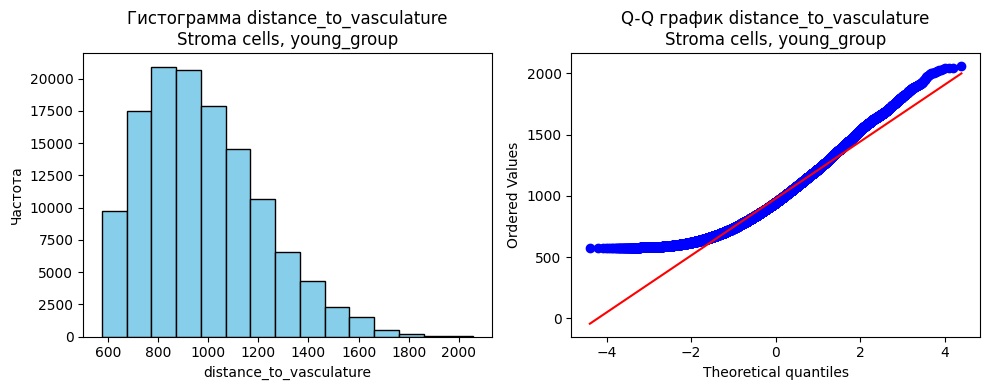


Комбинация: Тип клетки = Unclassified, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.9190853238105774, P-value = 0.0
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


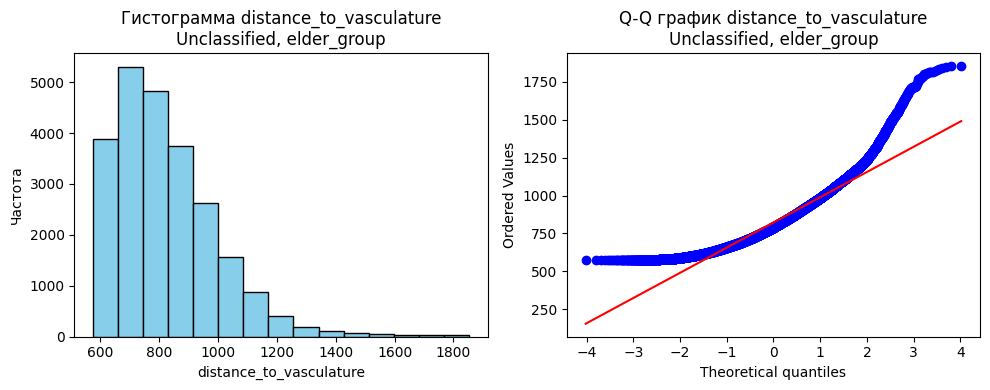


Комбинация: Тип клетки = Unclassified, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.9584923982620239, P-value = 0.0
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


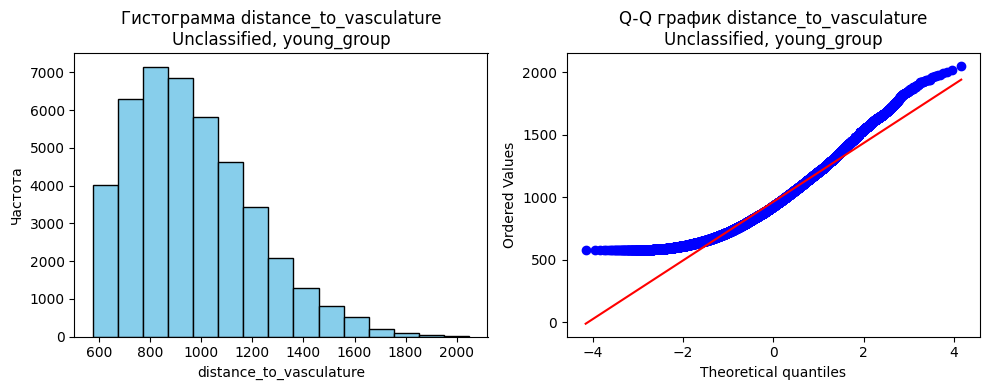


Комбинация: Тип клетки = Vasculature, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.8256980776786804, P-value = 4.8684993814163136e-09
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


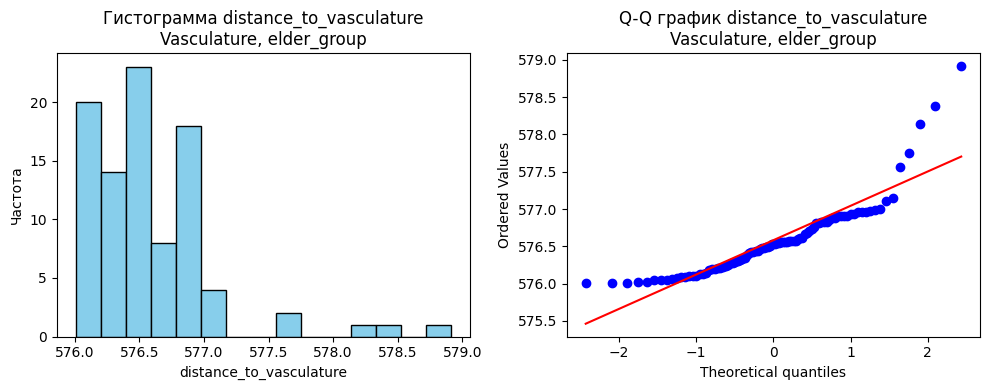


Комбинация: Тип клетки = Vasculature, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.5344419479370117, P-value = 1.3397311038332305e-11
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


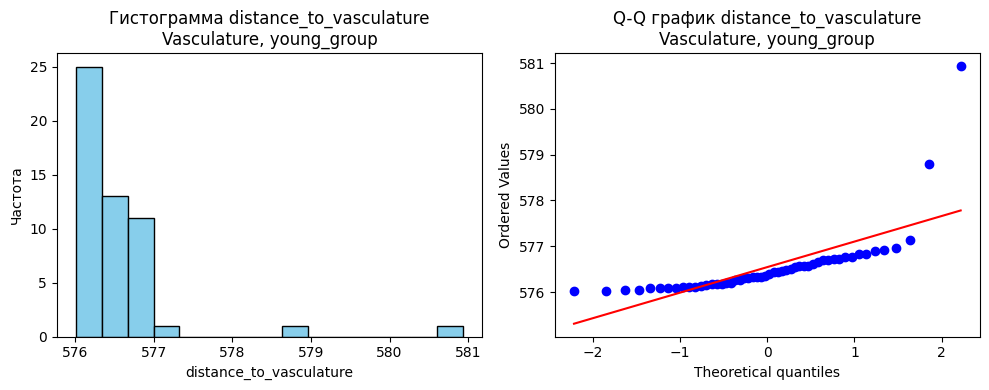

In [ ]:
# @title Тест Шапиро-Уилка для distance_to_vasculature
shapiro_wilk_test_visualization(data, 'distance_to_vasculature')


Комбинация: Тип клетки = Blood cells, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.7027682065963745, P-value = 2.5675902183994084e-29
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


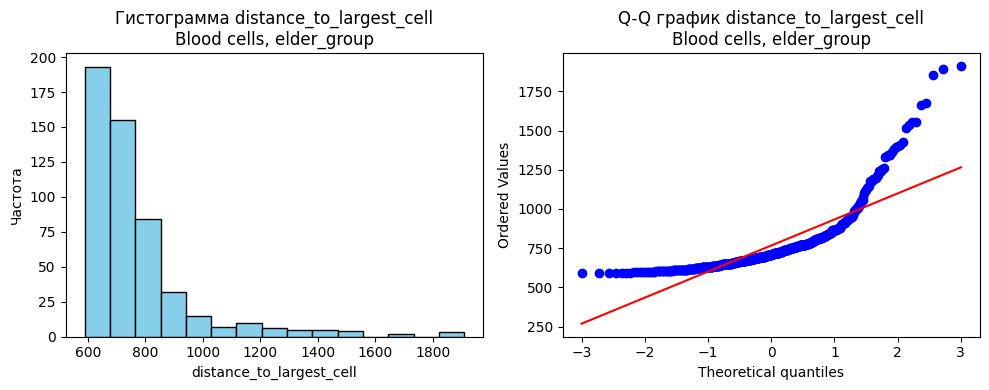


Комбинация: Тип клетки = Blood cells, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.8806260824203491, P-value = 7.555797115744021e-39
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


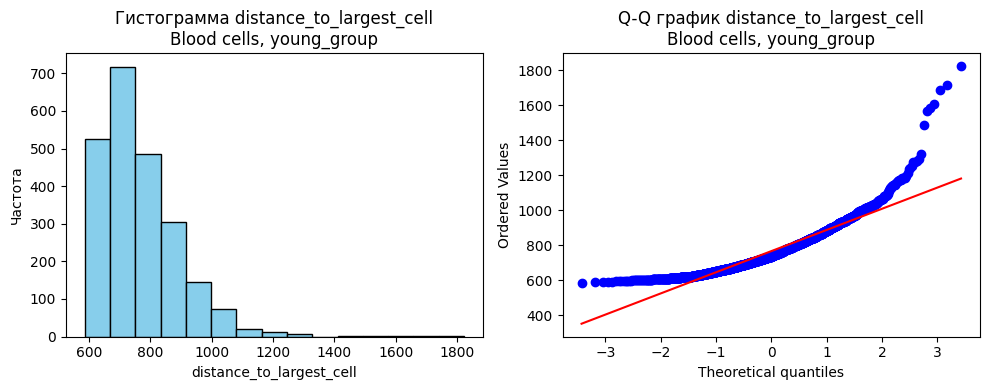


Комбинация: Тип клетки = Bone cells, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.7732043266296387, P-value = 6.981963009686195e-23
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


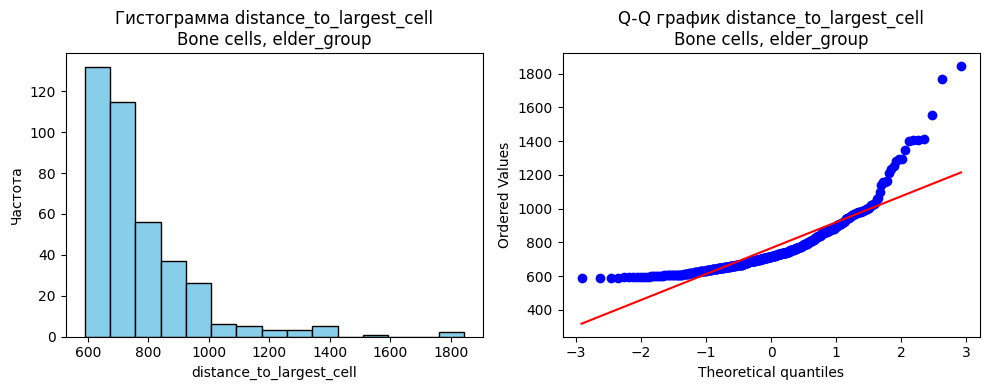


Комбинация: Тип клетки = Bone cells, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.9048275351524353, P-value = 9.52244670343985e-35
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


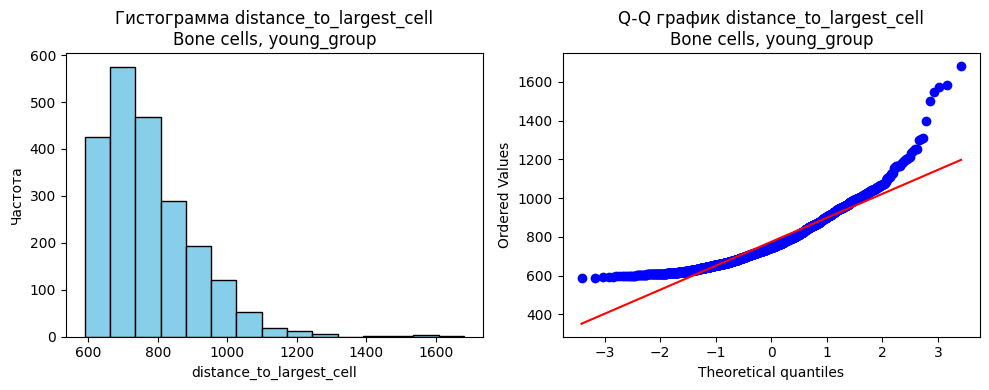


Комбинация: Тип клетки = Immune type 1, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.7887752056121826, P-value = 3.3853969599623256e-41
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


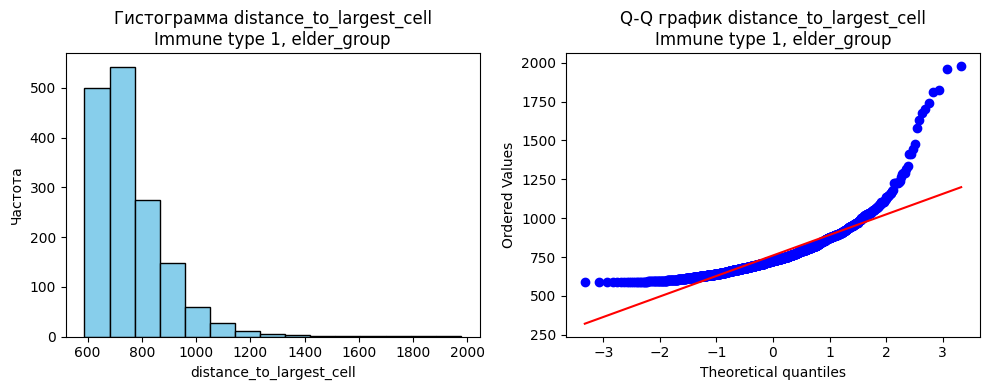


Комбинация: Тип клетки = Immune type 1, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.8108091354370117, P-value = 0.0
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


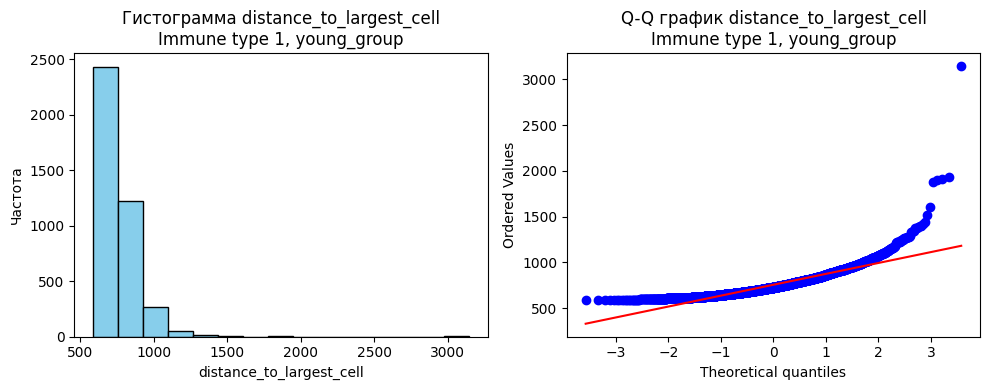

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Комбинация: Тип клетки = Immune type 2, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.791425347328186, P-value = 0.0
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


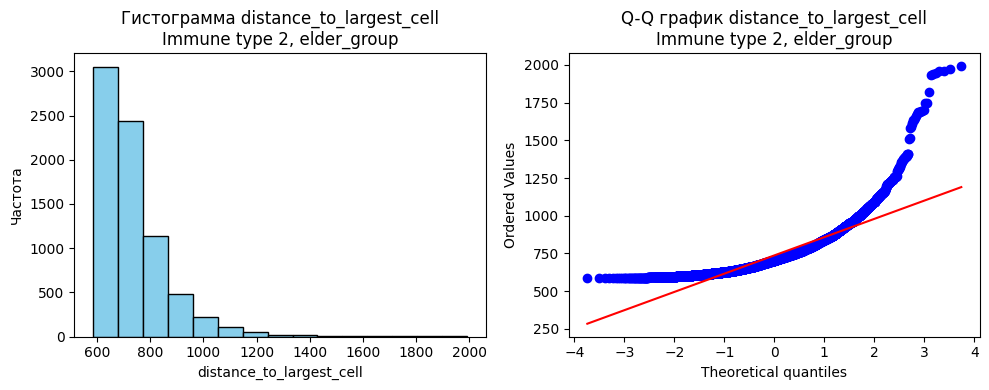


Комбинация: Тип клетки = Immune type 2, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.8367128372192383, P-value = 0.0
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


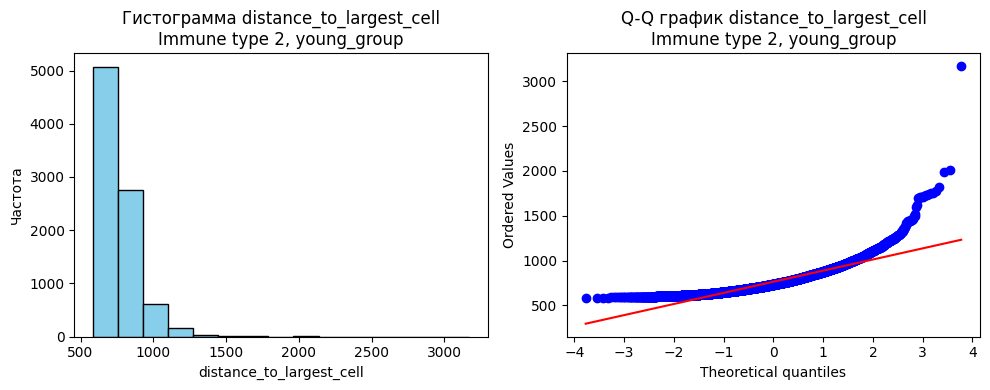


Комбинация: Тип клетки = Largest cells, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.9560785889625549, P-value = 1.4807022126226235e-15
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


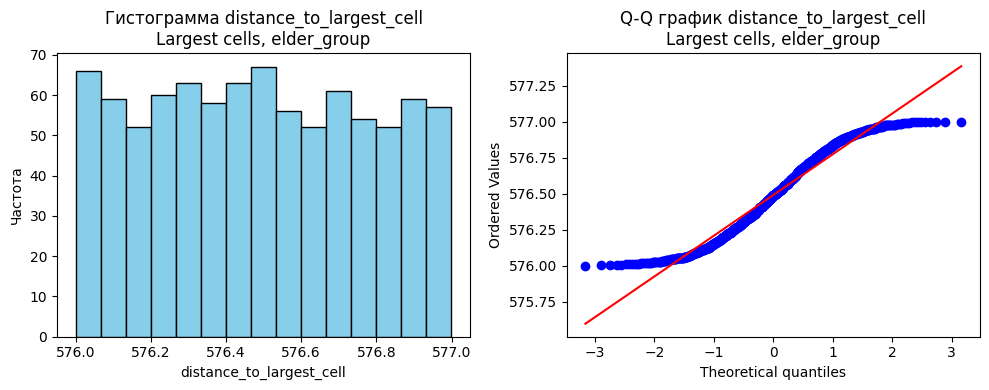


Комбинация: Тип клетки = Largest cells, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.9495898485183716, P-value = 4.919308760313977e-19
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


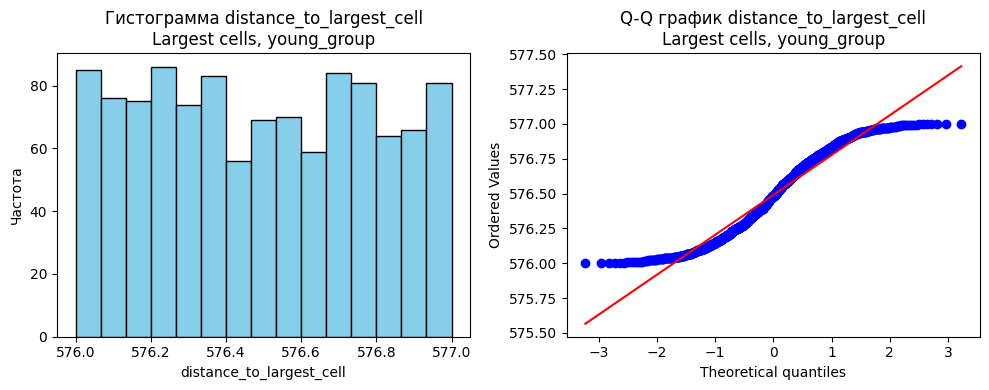


Комбинация: Тип клетки = Stroma cells, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.7607277631759644, P-value = 0.0
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


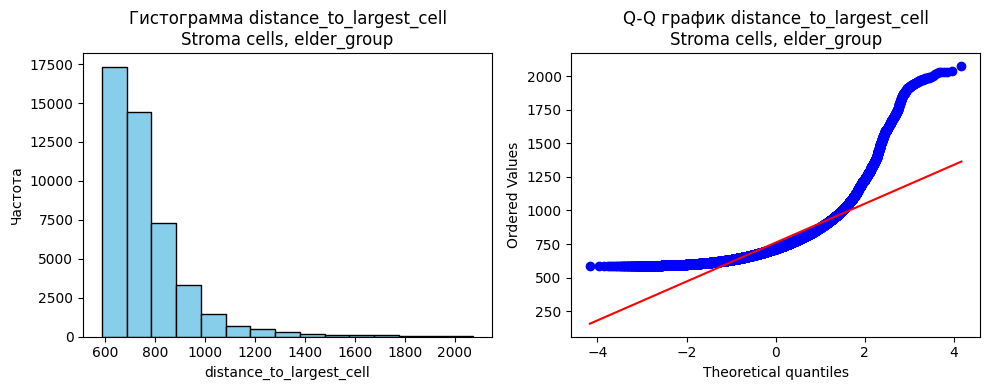


Комбинация: Тип клетки = Stroma cells, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.8633304834365845, P-value = 0.0
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


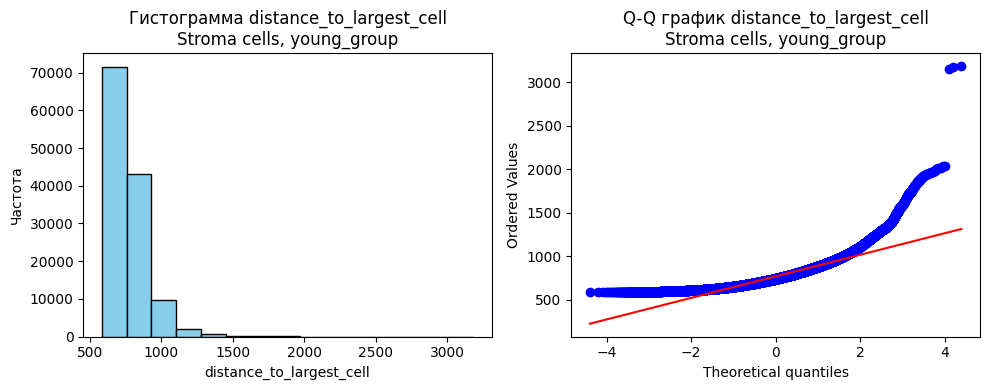


Комбинация: Тип клетки = Unclassified, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.7536782026290894, P-value = 0.0
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


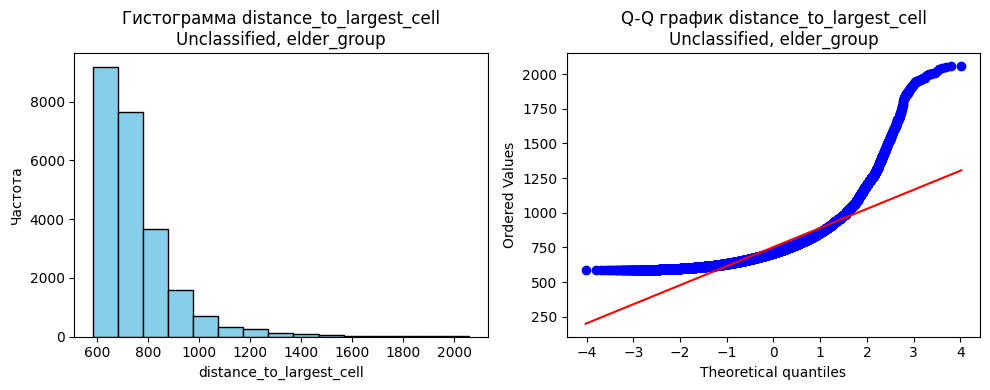


Комбинация: Тип клетки = Unclassified, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.8603560924530029, P-value = 0.0
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


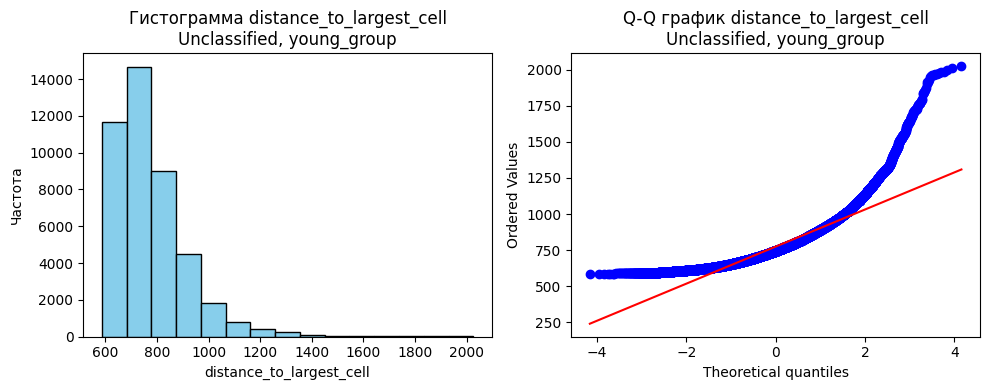


Комбинация: Тип клетки = Vasculature, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.7763363718986511, P-value = 1.6300426286530723e-10
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


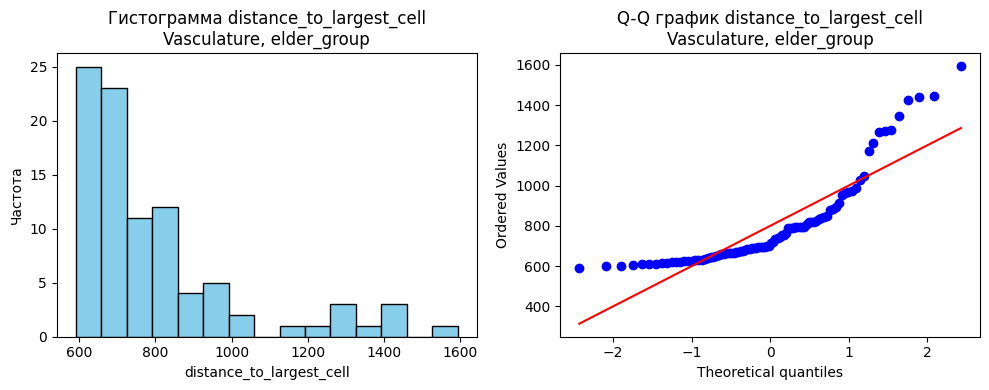


Комбинация: Тип клетки = Vasculature, Возрастная группа = young_group
Тест Шапиро-Уилка: Статистика = 0.7416251301765442, P-value = 3.2487189827179463e-08
Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)


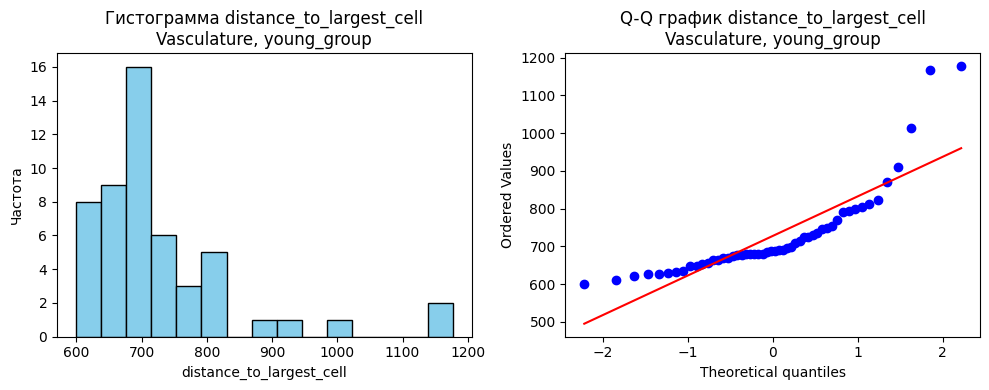

In [ ]:
# @title Тест Шапиро-Уилка для distance_to_largest_cell
shapiro_wilk_test_visualization(data, 'distance_to_largest_cell')

`H0`:  С возрастом расстояние не изменяется

`H1`:  Возраст влияет на расстояние

In [ ]:
# @title Тест Критерий Краскела-Уоллиса + Ранговый бисериальный корреляционный коэффициент для distance_to_vasculature
analyze_cell_types(data, 'distance_to_vasculature')


Тип клетки = Stroma cells
Критерий Краскела-Уоллиса: Статистика = 14956.22487014148, P-value = 0.0
Ранговый бисериальный корреляционный коэффициент = -0.26149383297966383
Есть статистически значимые различия между возрастными группами. (Отвергаем H0. Принимаем H1)
Маленький эффект.

Тип клетки = Unclassified
Критерий Краскела-Уоллиса: Статистика = 6045.996541779459, P-value = 0.0
Ранговый бисериальный корреляционный коэффициент = -0.280892772168108
Есть статистически значимые различия между возрастными группами. (Отвергаем H0. Принимаем H1)
Маленький эффект.

Тип клетки = Immune type 2
Критерий Краскела-Уоллиса: Статистика = 1518.0792855714462, P-value = 0.0
Ранговый бисериальный корреляционный коэффициент = -0.331917733877323
Есть статистически значимые различия между возрастными группами. (Отвергаем H0. Принимаем H1)
Средний эффект.

Тип клетки = Blood cells
Критерий Краскела-Уоллиса: Статистика = 233.67565552671476, P-value = 9.413917594004068e-53
Ранговый бисериальный корреляционн

##Результаты анализа и выводы

Для всех типов клеток, кроме 'Immune type 2'  и 'Vasculature' есть статистически значимые различия в расстоянии до сосудов между возрастными группами. Для клеток 'Immune type 2' наблюдается средний эффект, а для всех остальных типов клеток - эффект маленький.Данными для клеток сосудов 'Vasculature' можно пренебречь, так как расчет расстояния между клетками сосудов до ближайшего сосуда некорректен.



In [ ]:
# @title Тест Критерий Краскела-Уоллиса + Ранговый бисериальный корреляционный коэффициент для distance_to_largest_cell
analyze_cell_types(data, 'distance_to_largest_cell')


Тип клетки = Stroma cells
Критерий Краскела-Уоллиса: Статистика = 1095.7822949873516, P-value = 2.7263427227421726e-240
Ранговый бисериальный корреляционный коэффициент = -0.07078033233063515
Есть статистически значимые различия между возрастными группами. (Отвергаем H0. Принимаем H1)
Очень маленький эффект.

Тип клетки = Unclassified
Критерий Краскела-Уоллиса: Статистика = 1012.3011456377571, P-value = 3.8058918867435395e-222
Ранговый бисериальный корреляционный коэффициент = -0.11493742976397307
Есть статистически значимые различия между возрастными группами. (Отвергаем H0. Принимаем H1)
Маленький эффект.

Тип клетки = Immune type 2
Критерий Краскела-Уоллиса: Статистика = 330.7216194088396, P-value = 6.692959547992128e-74
Ранговый бисериальный корреляционный коэффициент = -0.1549225092393772
Есть статистически значимые различия между возрастными группами. (Отвергаем H0. Принимаем H1)
Маленький эффект.

Тип клетки = Blood cells
Критерий Краскела-Уоллиса: Статистика = 22.4929105367755

##Результаты анализа и выводы

Для всех типов клеток, кроме 'Largest cells' и 'Vasculature' есть статистически значимые различия в расстоянии до крупных клеток между возрастными группами. Однако в отличии от предыдущего случая эффект либо маленький, либо очень маленький, что говорит о меньшем влиянии возраста на расстояние до крупных клеток.

##Ограничения проведенного анализа
* Ограниченность выборки: Анализ может быть проведен на основе данных, которые не полностью представляют всё многообразие популяции. Если выборка мала или не достаточно разнообразна, это может привести к смещению результатов.

* Методологические ограничения: Использование критерия Краскела-Уоллиса и рангового бисериального коэффициента предполагает непараметрический подход, который может быть менее мощным по сравнению с параметрическими методами в случаях, когда данные соответствуют необходимым предпосылкам. Это может снизить точность выявления истинных статистических различий между группами.

* Внешние факторы: Влияние внешних переменных, таких как условия эксперимента, различия в процедурах сбора данных или биологические различия внутри групп, не всегда учитывается, что может вносить дополнительную вариабельность в результаты. Неконтролируемые внешние факторы могут вносить дополнительный шум в данные, усложняя интерпретацию результатов.

* Интерпретация размера эффекта: Величина эффекта интерпретируется в соответствии с общепринятыми порогами, которые могут не всегда соответствовать контексту конкретного исследования.

* Наличие выбросов может привести к смещению результатов


##Способы улучшения анализа
* Увеличение размера выборки: Расширение выборки позволит повысить точность оценок и улучшить обобщаемость результатов. Включение большего количества наблюдений из разнообразных групп уменьшит влияние случайных колебаний.

* Использование альтернативных методов: Применение дополнительных статистических методов, включая параметрические тесты (когда это уместно), а также многофакторный анализ, может дать более полное понимание взаимосвязей в данных.

* Почистить данные от выбросов

#Задача 2

2) В каком клеточном микроокружении клеток какого типа статистически больше, чем в других микроокружениях? (колонка `cell_interaction`). Для ответа используйте box_plot/swarplot с hue по микроокружениям, где:

по Ох будут типы клеток,
по Оу — их количество.
Не забудьте посчитать количество для каждого пациента отдельно, иначе выборка не будет репрезентативной.

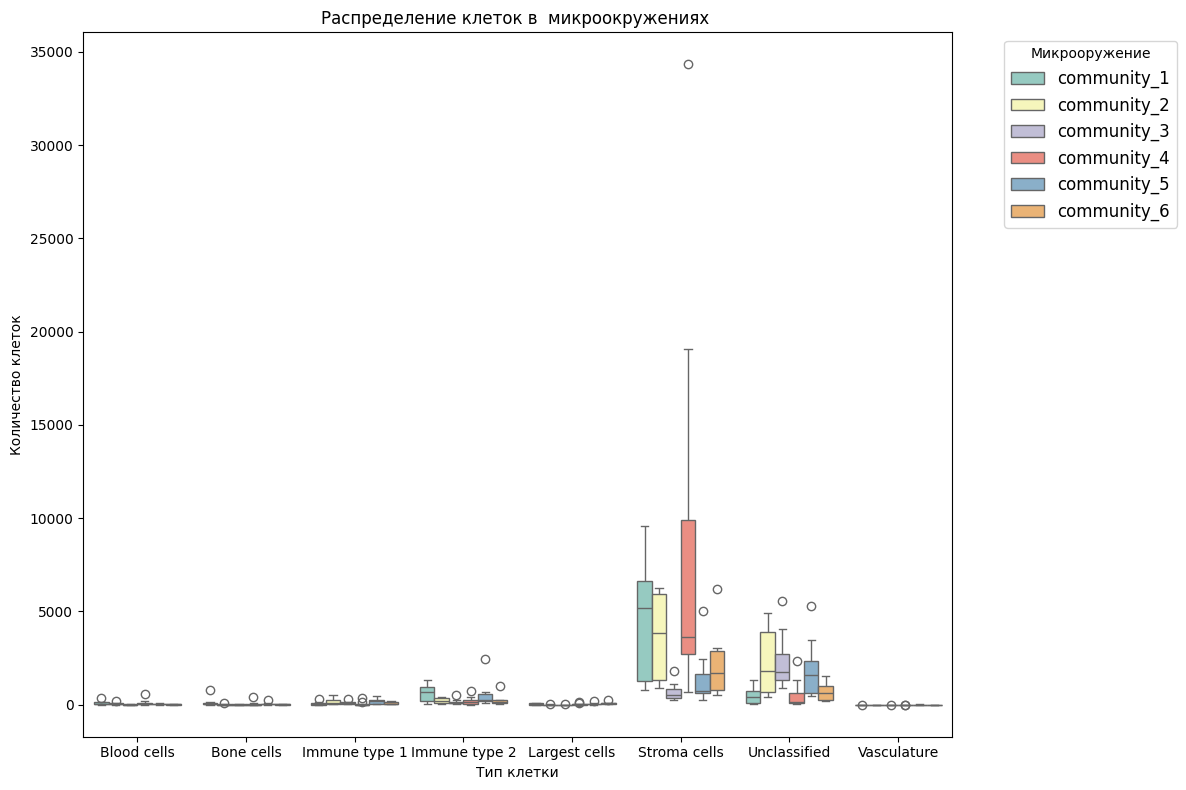

In [ ]:
# Подсчет количества клеток
cell_count = data.groupby(['case_id', 'cell_type', 'cell_interaction']).size().reset_index(name='cell_count')

# Создание диаграммы
plt.figure(figsize=(12, 8))
sns.boxplot(data=cell_count , x='cell_type', y='cell_count', hue='cell_interaction', palette="Set3")
plt.title('Распределение клеток в  микроокружениях ')
plt.ylabel('Количество клеток')
plt.xlabel('Тип клетки')
plt.legend(title='Микрооружение', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()


Стромальные клетки (Stroma cells) преобладают во всех микроокружениях, особенно в community_1 community_2 и community_4, где наблюдается значительно высокая медиана и большой разброс значений. Это может указывать на особую роль стромальных клеток или на наличие подгрупп пациентов с высокой плотностью стромальных клеток.
Некоторые типы клеток, такие как кровяные (Blood cells), костные (Bone cells) и связанные с сосудами (Vasculature cells), встречаются в меньшем количестве по всем микроокружениям.

In [ ]:
# @title Тест Шапиро-Уилка

# Подсчет количества клеток каждого типа в каждом клеточном микроокружении для каждого пациента
cell_count = data.groupby(['case_id', 'cell_type', 'cell_interaction']).size().reset_index(name='count')
cell_data = cell_count.pivot_table(index=['case_id', 'cell_type'], columns='cell_interaction', values='count', fill_value=0)

# Проводим тест Шапиро-Уилка
normality_tests = cell_data.groupby('cell_type').apply(lambda x: x.apply(lambda col: stats.shapiro(col)[1]))
normality_tests

cell_interaction  community_1  community_2  community_3  community_4  \
cell_type                                                              
Blood cells          0.019599     0.022029     0.090672     0.000511   
Bone cells           0.000039     0.000144     0.080501     0.000014   
Immune type 1        0.002413     0.052276     0.138308     0.000307   
Immune type 2        0.552156     0.211172     0.002750     0.061652   
Largest cells        0.447583     0.125492     0.029020     0.005032   
Stroma cells         0.352420     0.058284     0.045575     0.005778   
Unclassified         0.328164     0.162770     0.067235     0.003254   
Vasculature          0.128179     0.329713     0.042858     0.127426   

cell_interaction  community_5  community_6  
cell_type                                   
Blood cells          0.340092     0.221611  
Bone cells           0.005110     0.300450  
Immune type 1        0.421220     0.144431  
Immune type 2        0.000481     0.000973  
Largest cells        0.000295     0.073914  
Stroma cells         0.005795     0.062325  
Unclassified         0.099678     0.136523  
Vasculature          0.013082     0.063436

## Тест Левана
Тест Левена используется для проверки гомогенности (равенства) дисперсий между двумя или более группами.

`H0`: Дисперсии всех групп равны. Это означает, что нет статистически значимых различий в дисперсиях между сравниваемыми группами.

`H1`: По крайней мере, две группы имеют различные дисперсии. Это указывает на наличие статистически значимых различий в дисперсиях между сравниваемыми группами.

In [ ]:
# @title  Tеста Левена

# Проверка равенства дисперсий
levene_test = cell_data.groupby('cell_type').apply(lambda x: stats.levene(*[x[col] for col in cell_data.columns]))
levene_test

cell_type
Blood cells       (1.3868001311788205, 0.24874305198015748)
Bone cells         (1.0051086289800324, 0.4266449559036213)
Immune type 1      (1.1208716280739808, 0.3641146116666773)
Immune type 2      (1.068517275188098, 0.39143423928565185)
Largest cells     (1.3031612291106751, 0.28100145092713075)
Stroma cells       (2.195784731495364, 0.07271503076782526)
Unclassified      (2.396643277882494, 0.053281285448101214)
Vasculature      (2.5198342214328004, 0.044030184985814645)
dtype: object

На основе результатов теста Левена и установленного уровня значимости 0.05, мы не обнаружили статистически значимых различий в дисперсиях для большинства типов клеток по их микроокружениям. Это указывает на то, что дисперсии в различных группах клеток схожи, и данные соответствуют одному из предположений для проведения параметрических тестов, таких как ANOVA. Однако важно отметить, что ANOVA требует нормального распределения данных, которое не было подтверждено в данном случае.

Как следствие, если данные не распределены нормально,то целесообразнее использовать непараметрический тест.

`H0`: Не существует статистически значимых различий в количестве каждого типа клеток в разных клеточных микроокружениях. То есть, среднее количество клеток каждого типа одинаково во всех микроокружениях.

`H1`: Существует по крайней мере один тип клеток, количество которого статистически значимо отличается в различных клеточных микроокружениях. То есть, для как минимум одного типа клеток среднее количество клеток в одном или нескольких микроокружениях отличается от среднего количества клеток в других микроокружениях.

In [ ]:
# @title Тест Краскела-Уоллиса
kruskal_test = cell_data.groupby('cell_type').apply(lambda x: stats.kruskal(*[x[col] for col in cell_data.columns]))
kruskal_test

cell_type
Blood cells       (13.595872269911977, 0.018390883472722126)
Bone cells       (18.823178187153555, 0.0020734633395051508)
Immune type 1        (9.94262662179033, 0.07687731356218432)
Immune type 2       (8.730539572250546, 0.12030688182646924)
Largest cells    (23.78865699222782, 0.00023838374262455457)
Stroma cells     (18.727040816326507, 0.0021605838372889432)
Unclassified     (18.966836734693857, 0.0019496673303232715)
Vasculature          (4.936897286387061, 0.4236298280719951)
dtype: object

##Результаты анализа и выводы

Статистически значимые различия (p < 0.05) обнаружены для следующих типов клеток: Blood cells, Bone cells, Largest cells, Stroma cells, и Unclassified. Это указывает на то, что количество этих типов клеток статистически значимо отличается в разных клеточных микроокружениях.

Таким образом, результаты анализа подтверждают альтернативную гипотезу `H1` о том, что существуют статистически значимые различия в количестве определенных типов клеток в различных клеточных микроокружениях.

##Ограничения:
* Размер выборки: Маленький размер выборки может привести к недостаточной мощности статистических тестов, что затрудняет обнаружение значимых различий или связей.

* Выборочная репрезентативность: Если выборка не отражает всё многообразие популяции, результаты могут быть необобщаемы.

* Методологические ограничения: Использование непараметрических тестов, таких как тест Краскела-Уоллиса, может быть менее мощным, чем параметрические методы, и предоставлять меньше информации о величине эффектов.

* Предположения тестов: Каждый статистический тест имеет свои предположения (например, нормальность распределения, гомоскедастичность), нарушение которых может исказить результаты.

* Внешние факторы: Неучтенные переменные, такие как возраст, пол, образ жизни, могут влиять на результаты.

* Наличие выбросов в данных может исказить результаты

## Способы улучшения:
* Увеличение размера выборки: Больший объем данных повышает статистическую мощность и надежность результатов.

* Комплексное использование методов: Применение как параметрических, так и непараметрических методов может дать более полное представление о данных.

* Учет внешних факторов: Включение контрольных переменных для учета внешних факторов.

* Очистка данных от выбросов

#Задача 3

3) Есть ли разница в доле микроокружения в тканях пациентов разных возрастов? Для ответа используйте box_plot/swarplot с hue по возрастным группам, где:

по Ох будут микроокружения,
по Оу — их доля в ткани пациента.
Не забудьте посчитать доли для каждого пациента отдельно, иначе выборка не будет репрезентативной.


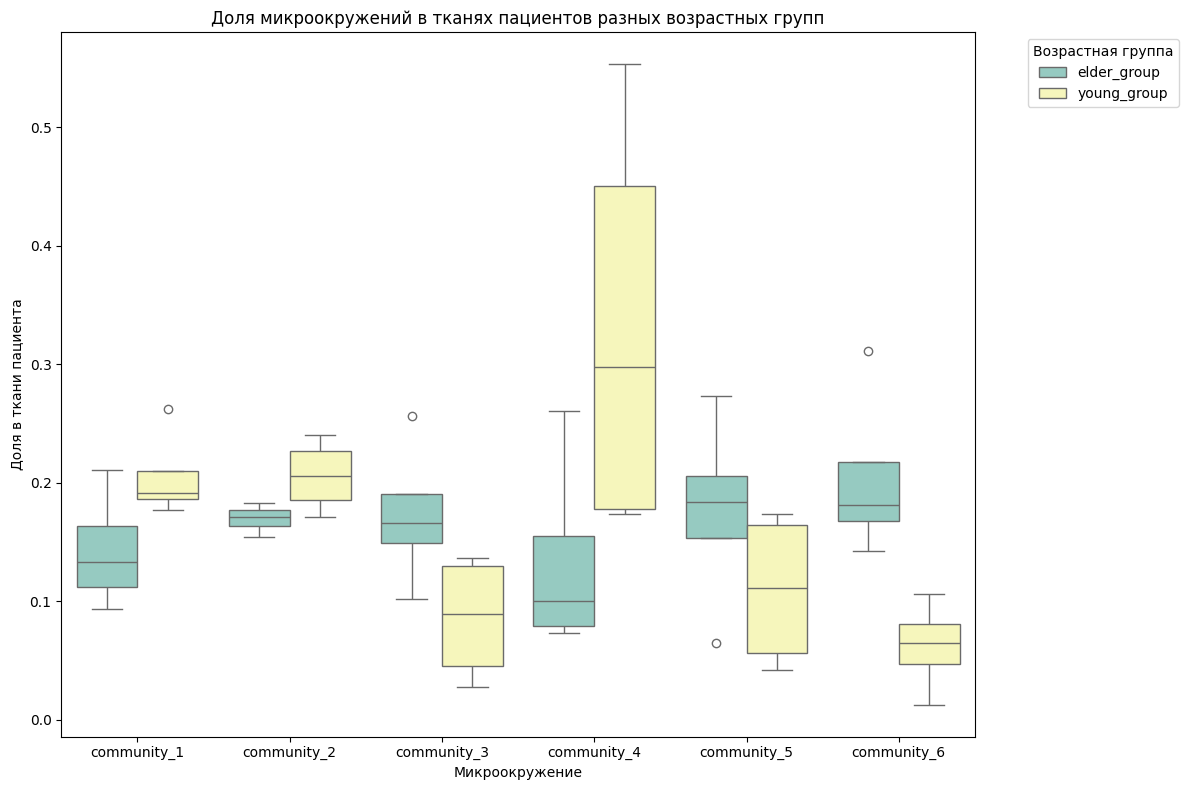

In [ ]:
# Группировка по пациентам и микроокружениям, расчет общего количества клеток в каждом микроокружении
grouped_data = data.groupby(['case_id', 'cell_interaction', 'age_group']).size().reset_index(name='count')

# Расчет общего количества клеток для каждого пациента
total_cells_per_patient = data.groupby(['case_id']).size().reset_index(name='total_count')

# Объединение данных для расчета доли
merged_data = pd.merge(grouped_data, total_cells_per_patient, on='case_id')
merged_data['proportion'] = merged_data['count'] / merged_data['total_count']

# Визуализация
plt.figure(figsize=(12, 8))
sns.boxplot(data=merged_data, x='cell_interaction', y='proportion', hue='age_group', palette="Set3")

plt.title('Доля микроокружений в тканях пациентов разных возрастных групп')
plt.xlabel('Микроокружение')
plt.ylabel('Доля в ткани пациента')
plt.legend(title='Возрастная группа', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

In [ ]:
# @title Тест Шапиро-Уилка

# Фильтрация данных по каждой возрастной группе и микроокружению
age_groups = merged_data['age_group'].unique()
cell_interactions = merged_data['cell_interaction'].unique()

# Проверка нормальности распределения долей микроокружений для каждой возрастной группы
normality_results = {}
for age_group in age_groups:
    normality_results[age_group] = {}
    for interaction in cell_interactions:
        sample = merged_data[(merged_data['age_group'] == age_group) & (merged_data['cell_interaction'] == interaction)]['proportion']
        stat, p = shapiro(sample)
        normality_results[age_group][interaction] = {'statistic': stat, 'p-value': p}
        print(f"\nКомбинация: Тип микроокружения = {interaction}, Возрастная группа = {age_group}")
        print(f"Тест Шапиро-Уилка: Статистика = {stat}, P-value = {p}")

        if p > 0.05:
            print('Данные соответсвуют нормальному распределению. (Принимаем H0)')
        else:
            print('Данные соответсвуют распределению отличному от нормального. (Отвергаем H0. Принимаем H1)')





Комбинация: Тип микроокружения = community_1, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.9527967572212219, P-value = 0.7336215376853943
Данные соответсвуют нормальному распределению. (Принимаем H0)

Комбинация: Тип микроокружения = community_2, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.9885565042495728, P-value = 0.9499619007110596
Данные соответсвуют нормальному распределению. (Принимаем H0)

Комбинация: Тип микроокружения = community_3, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.9407046437263489, P-value = 0.6586281061172485
Данные соответсвуют нормальному распределению. (Принимаем H0)

Комбинация: Тип микроокружения = community_4, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0.8039243817329407, P-value = 0.1094459816813469
Данные соответсвуют нормальному распределению. (Принимаем H0)

Комбинация: Тип микроокружения = community_5, Возрастная группа = elder_group
Тест Шапиро-Уилка: Статистика = 0

In [ ]:
# @title  Tеста Левена
# Подготовка данных для теста Левена на гомогенность дисперсий
levene_data = [merged_data[merged_data['cell_interaction'] == interaction]['proportion'] for interaction in cell_interactions]

# Проведение теста Левена
levene_stat, levene_p = levene(*levene_data)
(levene_stat, levene_p)


(2.1263157711244784, 0.0809609798849128)

Предположения о нормальности распределения и гомогенности дисперсий выполнены, можно использовать двухфакторный дисперсионный анализ (two-way ANOVA) с cell_interaction и age_group в качестве факторов.

In [ ]:
# @title Двухфакторный дисперсионный анализ (two-way ANOVA)
# Формирование модели для двухфакторного дисперсионного анализа
model = ols('proportion ~ C(cell_interaction) * C(age_group)', data=merged_data).fit()

# Проведение двухфакторного ANOVA
anova_results = sm.stats.anova_lm(model, typ=2)
anova_results


sum_sq    df             F    PR(>F)
C(cell_interaction)               6.309251e-02   5.0  2.062007e+00  0.093087
C(age_group)                      1.645065e-32   1.0  2.688224e-30  1.000000
C(cell_interaction):C(age_group)  1.524287e-01   5.0  4.981719e+00  0.001439
Residual                          2.203028e-01  36.0           NaN       NaN

In [ ]:
# @title Расчет парциального эта-квадрата для оценки величины эффекта

def calculate_partial_eta_squared(anova_df):
    """
    Расчет парциального эта-квадрата для каждого фактора и их взаимодействия на основе результатов ANOVA.
    """
    # Сумма квадратов для каждого фактора и их взаимодействия
    ss_effect = anova_df['sum_sq']

    # Общая сумма квадратов (включая остаточную)
    ss_total = sum(ss_effect)

    # Расчет парциального эта-квадрата
    partial_eta_squared = ss_effect / ss_total

    return partial_eta_squared

# Создаем DataFrame
anova_df = pd.DataFrame(anova_results)

# Расчет парциального эта-квадрата для наших данных
partial_eta_squared = calculate_partial_eta_squared(anova_df)
anova_df['partial_eta_squared'] = partial_eta_squared
anova_df


sum_sq    df             F    PR(>F)  \
C(cell_interaction)               6.309251e-02   5.0  2.062007e+00  0.093087   
C(age_group)                      1.645065e-32   1.0  2.688224e-30  1.000000   
C(cell_interaction):C(age_group)  1.524287e-01   5.0  4.981719e+00  0.001439   
Residual                          2.203028e-01  36.0           NaN       NaN   

                                  partial_eta_squared  
C(cell_interaction)                      1.447660e-01  
C(age_group)                             3.774608e-32  
C(cell_interaction):C(age_group)         3.497483e-01  
Residual                                 5.054857e-01


##Результаты анализа и выводы
Влияние типа микроокружения (C(cell_interaction)): Несмотря на то, что p-value (0.093087) выше установленного порога значимости (0.05), что указывает на отсутствие статистически значимых различий, размер эффекта составляет примерно 14.5% (0.1447660). Это говорит о том, что тип микроокружения объясняет значительную часть дисперсии доли микроокружений в ткани пациента, но этот эффект не достигает статистической значимости.


Влияние возрастной группы (C(age_group)): Статистически значимого влияния возрастной группы на долю микроокружений не обнаружено (p-value равно 1.000), и размер эффекта практически нулевой (3.774608e-32), что указывает на полное отсутствие влияния этого фактора.


Взаимодействие между типом микроокружения и возрастной группой (C(cell_interaction):C(age_group)): Наблюдается статистически значимое взаимодействие между этими факторами (p-value 0.001439) с размером эффекта примерно 34.97% (0.3497483). Это говорит о том, что влияние типа микроокружения на долю в ткани пациента значительно варьируется в зависимости от возрастной группы. Это указывает на то, что комбинация этих двух факторов имеет существенное и значимое влияние на изучаемый показатель.


Остаточная дисперсия (Residual): Показывает долю дисперсии (около 50.55% (0.5054857)), не объясненную моделью. Это демонстрирует, что в данных присутствуют другие факторы, влияющие на долю микроокружений в ткани пациента, которые не были включены в текущую модель.



## Ограничения:
* Ограничения выборки и методологии: Результаты могут быть ограничены выборкой и методологией исследования. Например, выборочная репрезентативность, размер выборки и предположения статистических тестов могут ограничить обобщаемость результатов.

* Внешние факторы: Неучтенные внешние переменные могут вносить смещение в результаты. Отсутствие значимого влияния каждого из факторов по отдельности и высокая остаточная дисперсия подчеркивают необходимость дальнейшего изучения других потенциальных факторов, которые могли бы объяснить изменчивость доли микроокружений в тканях пациента. Это может включать более детальное рассмотрение различных типов тканей, генетических факторов, состояния здоровья и других демографических переменных.

##Улучшения:

* Увеличение размера выборки может повысить мощность анализа и точность оценок величины эффекта.
* Использование более сложных статистических моделей (например, многоуровневый анализ) может помочь учесть внешние факторы и иерархическую структуру данных.
Контроль за внешними переменными через стратификацию или включение в модель как ковариатов поможет минимизировать смещение.

#Задача 4

4) Правда ли, что иммунные клетки (`Immune type 1` и `Immune type 2`) лежат ближе к сосудам и крупным клеткам (Обе колонки `distance`), чем стромальные клетки (`Stroma cells`) у молодых, но не у пожилых пациентов? Эту гипотезу нужно проверить бутстрапом (как разницу средних для двух выборок).


In [ ]:
# Определение интересующих типов клеток
cells_of_interest = ['Immune type 1', 'Immune type 2', 'Stroma cells']

# Фильтрация данных для получения только нужных типов клеток
filtered_data = data[data['cell_type'].isin(cells_of_interest)]

# Далее, разделяем данные по возрастным группам
young_cells = filtered_data[filtered_data['age_group'] == 'young_group']
old_cells = filtered_data[filtered_data['age_group'] == 'elder_group']

# Для бутстрап-анализа нам нужны отдельные DataFrame для иммунных и стромальных клеток в каждой возрастной группе
young_immune_cells = young_cells[young_cells['cell_type'].isin(['Immune type 1', 'Immune type 2'])]
young_stroma_cells = young_cells[young_cells['cell_type'] == 'Stroma cells']

old_immune_cells = old_cells[old_cells['cell_type'].isin(['Immune type 1', 'Immune type 2'])]
old_stroma_cells = old_cells[old_cells['cell_type'] == 'Stroma cells']

In [ ]:
# Функция для расчета разницы средних значений
def bootstrap_mean_difference(data_1, data_2, n_bootstrap=10000):
    mean_diffs = []
    for _ in range(n_bootstrap):
        sample1 = data_1.sample(n=len(data_1), replace=True)
        sample2 = data_2.sample(n=len(data_2), replace=True)
        mean_diff = sample1.mean() - sample2.mean()
        mean_diffs.append(mean_diff)
    return mean_diffs

# Проводим тест для distance_to_vasculature  у молодых пациентов
test_mean_diffs = bootstrap_mean_difference(young_immune_cells['distance_to_vasculature'],
                                      young_stroma_cells['distance_to_vasculature'])
print("Разница средних значений:")
print(test_mean_diffs[:5])

Разница средних значений:
[-24.58709876588739, -27.3827679840781, -23.191582409409307, -27.37025903273468, -26.5101082876281]


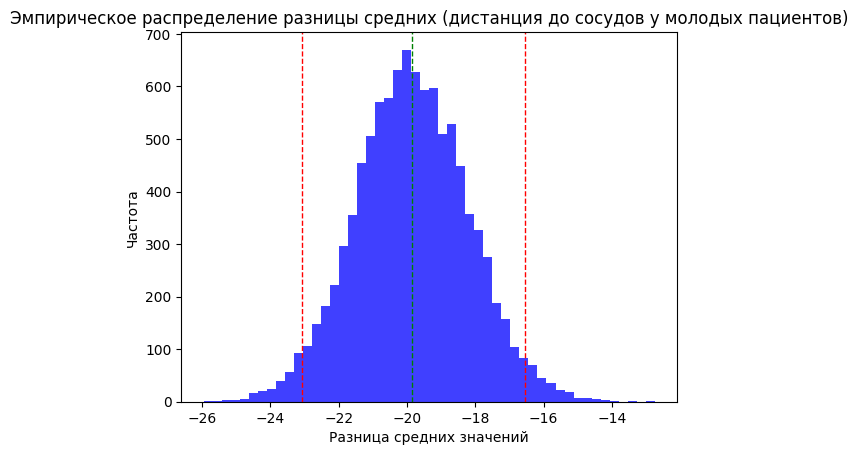

(-23.077223870377228, -16.539702194239517, -19.840991875529216)

In [ ]:
# @title Эмпирическое распределение разницы средних (дистанция до сосудов у молодых пациентов)
# Построение гистограммы эмпирического распределения разницы средних
plt.hist(test_mean_diffs, bins=50, alpha=0.75, color='blue')
plt.xlabel('Разница средних значений')
plt.ylabel('Частота')
plt.title('Эмпирическое распределение разницы средних (дистанция до сосудов у молодых пациентов)')
plt.axvline(np.percentile(test_mean_diffs, 2.5), color='red', linestyle='dashed', linewidth=1)
plt.axvline(np.percentile(test_mean_diffs, 97.5), color='red', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(test_mean_diffs), color='green', linestyle='dashed', linewidth=1)
plt.show()

# Вывод доверительного интервала
ci_lower = np.percentile(test_mean_diffs, 2.5)
ci_upper = np.percentile(test_mean_diffs, 97.5)
mean_diff = np.mean(test_mean_diffs)
ci_lower, ci_upper, mean_diff

In [ ]:
# Проводим тест для distance_to_vasculature  у пожилых пациентов
test_mean_diffs = bootstrap_mean_difference(old_immune_cells['distance_to_vasculature'],
                                      old_stroma_cells['distance_to_vasculature'])
print("Разница средних значений:")
print(test_mean_diffs[:5])

Разница средних значений:
[-25.387257578030585, -25.865509626506082, -29.37818932118614, -25.23838841424947, -26.83852385819182]


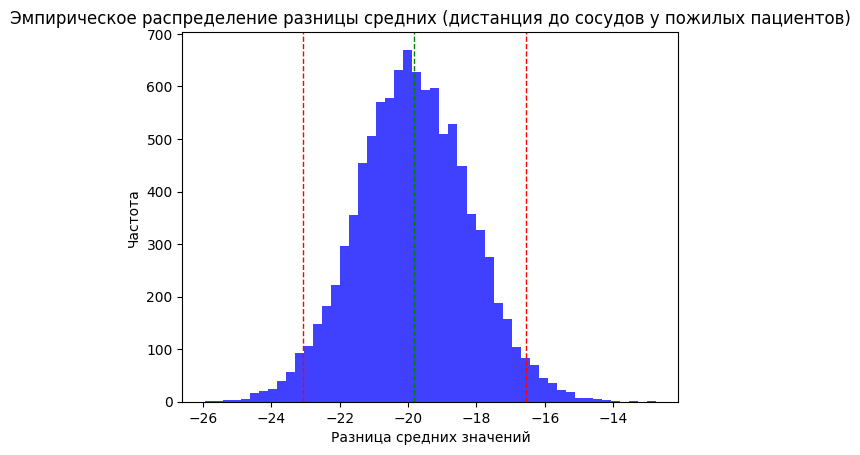

(-23.077223870377228, -16.539702194239517, -19.840991875529216)

In [ ]:
# @title Эмпирическое распределение разницы средних (дистанция до сосудов у пожилых пациентов)
# Построение гистограммы эмпирического распределения разницы средних
plt.hist(test_mean_diffs, bins=50, alpha=0.75, color='blue')
plt.xlabel('Разница средних значений')
plt.ylabel('Частота')
plt.title('Эмпирическое распределение разницы средних (дистанция до сосудов у пожилых пациентов)')
plt.axvline(np.percentile(test_mean_diffs, 2.5), color='red', linestyle='dashed', linewidth=1)
plt.axvline(np.percentile(test_mean_diffs, 97.5), color='red', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(test_mean_diffs), color='green', linestyle='dashed', linewidth=1)
plt.show()

# Вывод доверительного интервала
ci_lower = np.percentile(test_mean_diffs, 2.5)
ci_upper = np.percentile(test_mean_diffs, 97.5)
mean_diff = np.mean(test_mean_diffs)
ci_lower, ci_upper, mean_diff

In [ ]:
# Проводим тест для distance_to_largest_cell  у молодых пациентов
test_mean_diffs = bootstrap_mean_difference(young_immune_cells['distance_to_largest_cell'],
                                      young_stroma_cells['distance_to_largest_cell'])
print("Разница средних значений:")
print(test_mean_diffs[:5])


Разница средних значений:
[-8.624549400511, -6.330462925354027, -6.312599216735293, -7.247969897388657, -5.2399000411267025]


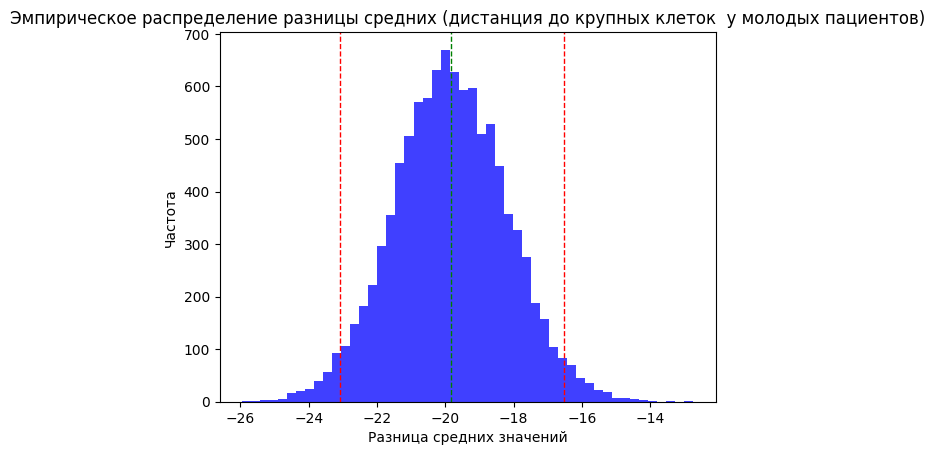

(-23.077223870377228, -16.539702194239517, -19.840991875529216)

In [ ]:
# @title Эмпирическое распределение разницы средних (дистанция до крупных клеток у молодых пациентов)
# Построение гистограммы эмпирического распределения разницы средних
plt.hist(test_mean_diffs, bins=50, alpha=0.75, color='blue')
plt.xlabel('Разница средних значений')
plt.ylabel('Частота')
plt.title('Эмпирическое распределение разницы средних (дистанция до крупных клеток  у молодых пациентов)')
plt.axvline(np.percentile(test_mean_diffs, 2.5), color='red', linestyle='dashed', linewidth=1)
plt.axvline(np.percentile(test_mean_diffs, 97.5), color='red', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(test_mean_diffs), color='green', linestyle='dashed', linewidth=1)
plt.show()

# Вывод доверительного интервала
ci_lower = np.percentile(test_mean_diffs, 2.5)
ci_upper = np.percentile(test_mean_diffs, 97.5)
mean_diff = np.mean(test_mean_diffs)
ci_lower, ci_upper, mean_diff

In [ ]:
# Проводим тест для distance_to_largest_cell  у пожилых пациентов
test_mean_diffs = bootstrap_mean_difference(old_immune_cells['distance_to_largest_cell'],
                                      old_stroma_cells['distance_to_largest_cell'])
print("Разница средних значений:")
print(test_mean_diffs[:5])

Разница средних значений:
[-20.861078352316554, -21.293453401954707, -20.689981710544657, -20.607276313797684, -17.65018684648294]


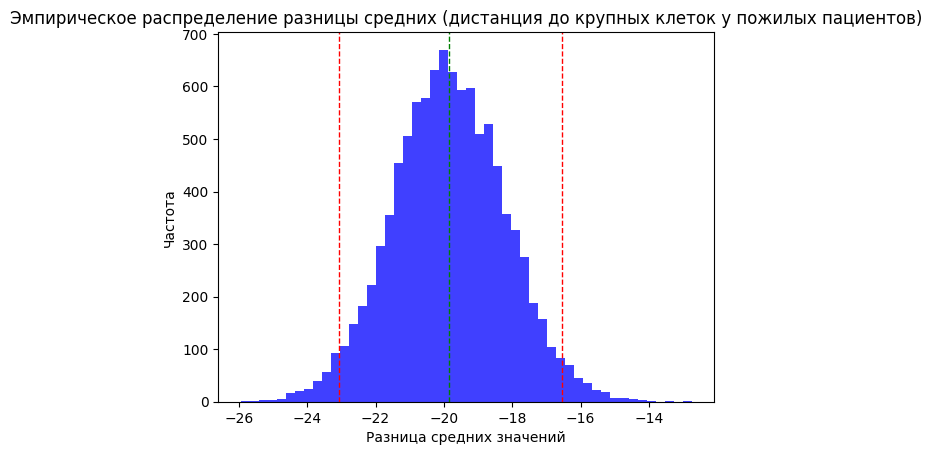

(-23.077223870377228, -16.539702194239517, -19.840991875529216)

In [ ]:
# @title Эмпирическое распределение разницы средних (дистанция до крупных клеток у пожилых пациентов)
# Построение гистограммы эмпирического распределения разницы средних
plt.hist(test_mean_diffs, bins=50, alpha=0.75, color='blue')
plt.xlabel('Разница средних значений')
plt.ylabel('Частота')
plt.title('Эмпирическое распределение разницы средних (дистанция до крупных клеток у пожилых пациентов)')
plt.axvline(np.percentile(test_mean_diffs, 2.5), color='red', linestyle='dashed', linewidth=1)
plt.axvline(np.percentile(test_mean_diffs, 97.5), color='red', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(test_mean_diffs), color='green', linestyle='dashed', linewidth=1)
plt.show()

# Вывод доверительного интервала
ci_lower = np.percentile(test_mean_diffs, 2.5)
ci_upper = np.percentile(test_mean_diffs, 97.5)
mean_diff = np.mean(test_mean_diffs)
ci_lower, ci_upper, mean_diff

## Результаты и выводы
Доверительный интервал для разницы средних расстояния до сосудов и крупных клеток не включает нуль ни для молодых пациентов, ни для пожилых пациентов, что означает, что исходная гипотеза отвергается и иммунные клетки (Immune type 1 и Immune type 2) не лежат ближе к сосудам и крупным клеткам, чем стромальные клетки

In [ ]:
#Расчет t-теста и p-значения для молодых пациентов

# Проводим тест для distance_to_vasculature  у молодых пациентов
t_statistic_young, p_value_young_vasc = stats.ttest_ind(young_immune_cells['distance_to_vasculature'],
                                                         young_stroma_cells['distance_to_vasculature'])
print("P-value у молодых пациеентов для distance_to_vasculature:", p_value_young_vasc)

# Проводим тест для distance_to_vasculature  у пожилых пациентов
t_statistic_young, p_value_old_vasc = stats.ttest_ind(old_immune_cells['distance_to_vasculature'],
                                                         old_stroma_cells['distance_to_vasculature'])
print("P-value у молодых пациеентов для distance_to_vasculature:", p_value_old_vasc)

# Проводим тест для distance_to_largest_cell  у молодых пациентов
t_statistic_young, p_value_young_vasc = stats.ttest_ind(young_immune_cells['distance_to_largest_cell'],
                                                         young_stroma_cells['distance_to_largest_cell'])
print("P-value у молодых пациеентов для distance_to_largest_cell:", p_value_young_vasc)

# Проводим тест для distance_to_largest_cell  у пожилых пациентов
t_statistic_young, p_value_old_vasc = stats.ttest_ind(old_immune_cells['distance_to_largest_cell'],
                                                         old_stroma_cells['distance_to_largest_cell'])
print("P-value у молодых пациеентов для distance_to_largest_cell:", p_value_old_vasc)


P-value у молодых пациеентов для distance_to_vasculature: 1.2542033206847492e-28
P-value у молодых пациеентов для distance_to_vasculature: 3.934298654113796e-40
P-value у молодых пациеентов для distance_to_largest_cell: 2.4782696446102667e-08
P-value у молодых пациеентов для distance_to_largest_cell: 1.3589152978189015e-26


Расстояние до сосудов (distance_to_vasculature): Статистически значимые p-значения (1.2542033206847492e-28 и 3.934298654113796e-40) подтверждают гипотезу о наличии значительных различий в расстоянии до сосудов между иммунными и стромальными клетками у молодых пациентов. Это указывает на то, что одна из групп клеток (вероятно, иммунные клетки) может быть расположена ближе к сосудам по сравнению с другой группой.

Расстояние до крупных клеток (distance_to_largest_cell): Аналогично, очень низкие p-значения (2.4782696446102667e-08 и 1.3589152978189015e-26) указывают на статистически значимые различия в расстоянии до крупных клеток между иммунными и стромальными клетками у молодых пациентов. Это подтверждает, что расположение одной из групп клеток относительно крупных клеток значительно отличается от другой группы.

В нашем случае результаты бутстрапа и t-теста противоречат друг другу. Однако при небольших размерах выборки бутстрап может быть менее надежным из-за повышенного влияния случайных колебаний и выбросов в данных.Также учитывая высоко значимые p-значения (близкие к 0), полученные в результате t-теста, можно сделать вывод о наличии статистически значимых различий между средними расстояниями до сосудов и крупных клеток для иммунных и стромальных клеток среди молодых и пожилых пациентов. Эти результаты подтверждают исходную гипотезу исследования

#Задача 5
5) Правда ли, что иммунные клетки в среднем лежат ближе к сосудам у молодых, но не у пожилых пациентов? Эту гипотезу необходимо проверить пермутационным тестом. В качестве исходной статистики берем массив с расстояниями только для данного типа клеток (длина - n), запоминаем среднее для каждого пациента. На каждой итерации набираем выборку размером n из всей! колонки с расстояниями до сосудов и смотрим соотношение с исходной статистикой. Проверяем гипотезы. Комбинировать p-values для каждой возрастной группы можно с помощью этого инструмента.

In [ ]:
# Определение иммунных клеток
immune_cells = ['Immune type 1', 'Immune type 2']

# Фильтрация данных по группам возраста и типу клеток
young_immune = data[(data['age_group'] == 'young_group') & (data['cell_type'].isin(immune_cells))]
elder_immune = data[(data['age_group'] == 'elder_group') & (data['cell_type'].isin(immune_cells))]

# Расчет среднего расстояния до сосудов для каждого пациента
mean_dist_young = young_immune.groupby('case_id')['distance_to_vasculature'].mean()
mean_dist_old = elder_immune.groupby('case_id')['distance_to_vasculature'].mean()


`H0`: Нет различий в среднем расстоянии от иммунных клеток до сосудов между молодыми и пожилыми группами пациентов

`H1`: Иммунные клетки в среднем лежат ближе к сосудам у молодых, но не у пожилых пациентов

In [ ]:
#@title Пермутационный тест

def permutation_test(group, pool, n_permutations=10000):
    observed_mean = group.mean()
    greater_count = 0

    for _ in range(n_permutations):
        # Случайная выборка из пула значений
        random_sample = np.random.choice(pool, size=len(group), replace=True)
        # Расчет среднего значения случайной выборки
        random_mean = np.mean(random_sample)
        # Сравнение с наблюдаемым средним
        if random_mean <= observed_mean:
            greater_count += 1

    # Расчет p-значения
    p_value = greater_count / n_permutations
    return p_value

# Создание пула всех значений distance_to_vasculature для каждой возрастной группы
pool_young = young_immune['distance_to_vasculature'].values
pool_old = elder_immune['distance_to_vasculature'].values

# Выполнение пермутационного теста для молодых и пожилых групп
p_value_young = permutation_test(mean_dist_young, pool_young)
p_value_old = permutation_test(mean_dist_old, pool_old)

# Объединение p-значений для молодых и пожилых групп с помощью метода Фишера
combined_p_value = combine_pvalues([p_value_young, p_value_old], method='fisher')[1]

print(f'P-Value для молодых пациентов {p_value_young}')
print(f'P-Value для пожилых пациентов { p_value_old}')
print(f'Объединение P-Value для молодых и пожилых групп с помощью метода Фишера {combined_p_value}')


P-Value для молодых пациентов 0.4538
P-Value для пожилых пациентов 0.5616
Объединение P-Value для молодых и пожилых групп с помощью метода Фишера 0.6032559518929939


## Результаты и выводы
P-Value для молодых пациентов (0.454) и p-Value для пожилых пациентов (0.561) значительно превышают стандартный порог статистической значимости 0.05. Это указывает на то, что нет достаточных статистических доказательств для отклонения нулевой гипотезы о том, что нет различий в среднем расстоянии от иммунных клеток до сосудов между молодыми и пожилыми группами пациентов.

Объединенное p-value (0.6030370619810121), полученное с помощью метода Фишера, также значительно превышает уровень значимости 0.05. Это подтверждает вывод о том, что на общем уровне нет статистически значимых различий в расположении иммунных клеток относительно сосудов между молодыми и пожилыми пациентами.

Вывод:
На основе пермутационного теста и последующего объединения p-значений можно заключить, что гипотеза о том, что иммунные клетки в среднем лежат ближе к сосудам у молодых пациентов по сравнению с пожилыми, не находит подтверждения в предоставленных данных.

## Ограничения проведенного анализа
* Размер выборки: Один из ключевых аспектов, влияющих на статистическую мощность анализа, — размер выборки. Маленькие выборки увеличивают вероятность ошибки второго рода (не обнаружение реального эффекта, когда он существует), что может привести к недостаточно убедительным результатам.

* Представительность выборки: Если выборка не является репрезентативной для всей популяции, результаты исследования могут быть смещены и не отражать реальных закономерностей.

* Внешние факторы: Неконтролируемые внешние факторы, такие как образ жизни пациентов, их медицинская история или конкретные условия окружающей среды, могут исказить результаты.

* Используемые инструменты и методологии: Пермутационный тест и метод Фишера для объединения p-значений имеют свои ограничения и предположения. Например, пермутационные тесты могут быть не такими эффективными при анализе данных с высокой степенью неравномерности или когда истинные распределения данных значительно отличаются от нормальных.

## Способы улучшения анализа
* Увеличение размера выборки: Расширение выборки улучшит статистическую мощность и позволит более уверенно обнаруживать малые эффекты.

* Улучшение репрезентативности: Использование стратифицированной выборки или сбалансированных групп поможет сделать выборку более представительной.

* Контроль за внешними факторами: Использование ковариат в анализе или проведение многофакторного анализа поможет учесть влияние внешних переменных.

* Применение альтернативных статистических методов: Использование других статистических методов или инструментов, более подходящих для конкретного типа данных и исследовательских вопросов, может улучшить качество анализа.
